In [34]:
import numpy as np
import csv
from datetime import datetime, date, time, timezone
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import glob
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

In [35]:
import numpy as np
import csv
from datetime import datetime, date, time, timezone

def convert_to_datetime(possible_date):
    return datetime.strptime(possible_date, "%d.%m.%Y - %H:%M:%S")

def read_data_csv(file_name, debug=False):
    sensorId = 0
    functionalisations = []
    failures = []
    #dict with timestamp as key and channels as values
    base_levels = {}
    classes = []

    #stored in the form of timestamp as key, as value you have another dictionary with 'channels', 'label', 'pred_label'
    data = {}


    with open(file_name) as csvfile:
        reader = csv.reader(csvfile, delimiter=';')
        #skip the first line 
        next(reader)
        #get sensor ID, dont know if that's every useful but hey :D
        sensorId = [int(s) for s in next(reader)[0].split(':') if s.isdigit()][0]
        #get non-working channels
        failures = [int(c) for c in next(reader)[0].split(':')[1]]
        #get the functionalisation of the different channels
        functionalisations = next(reader)
        functionalisations[0] = functionalisations[0].split(':')[1]
        #get already calculated base-levels
        s = next(reader)
        while s[0].startswith('#baseLevel'):
            base_levels[convert_to_datetime(s[0][11:])] = s[1:]
            s = next(reader)

        #get classes
        classes = s
        classes[0] = classes[0].split(':')[1]

        #skip header
        next(reader)

        if debug:
            print(sensorId)
            print(failures)
            print(functionalisations)
            print(base_levels)
            print(classes)

        #parsing data
        for row in reader:
            row_data = {}
            row_data['channels'] = np.array(row[1:-2]).astype(np.float) 
            row_data['label'] = row[-2]
            row_data['pred_label'] = row[-1]
            data[convert_to_datetime(row[0])] = row_data

        if debug:
            print(data)
    return sensorId, failures, functionalisations, base_levels, classes, data

def read_all_files_in_folder(folder_name, extension="csv", debug=False):
    all_data = {}
    for file in glob.glob(os.path.join(folder_name,'*.{}'.format(extension))):
        sensorId, failures, functionalisations, base_levels, classes, data = read_data_csv(file,debug)
        all_data.update(data)
        
    return sensorId, failures, functionalisations, base_levels, classes, all_data

In [36]:
def standardize_measurements(data, num_channels=64, use_last=5, debug=False):
    in_label = False
    prev_meas = None
    
    for ts in data:
        row_data = data[ts]
        
        if prev_meas is None:
            prev_meas = row_data['channels']
        else:
            if debug:
                #print("row data shape:",np.array(row_data['channels']).shape)
                #print("prev_meas shape:", prev_meas.shape)
                #print("row_data label: ",row_data['label'])
                print(ts)
            prev_meas = np.vstack((prev_meas, row_data['channels']))
            prev_meas = prev_meas[-use_last:, :]
            
        #assuming that two different labels are not directly after one another
        if row_data['label'] != '' and not in_label:
            in_label = True
            current_means = np.mean(prev_meas, axis=0)
        
        if row_data['label'] == '':
            in_label = False
            
        if in_label:
            if debug:
                print("current_means:", current_means)
                print("channels:",row_data['channels'])
                print("standardized:",row_data['channels']/current_means)
            row_data['channels'] = row_data['channels']/current_means
            
    return data

In [37]:
def get_labeled_measurements(data, debug=False):
    current_label = ''
    
    current_measurement = None
    
    measurements = {}
    meas_data = {}
    
    for ts in data:
        row_data = data[ts]
        if debug:
            ##print("row data label:",row_data['label'])
            #print("current label:", current_label)
            same = current_label == row_data['label']
            issame = current_label is row_data['label']
            #print("same:",same,"; issame:",issame)
        
        if current_label != row_data['label']:
            #change of labels
            if debug:
                print("change in labels; cl:",current_label," - rdl:",row_data['label'])
            
            if current_label != '':
                if debug:
                    print("new measurement; cl:",current_label," - rdl:",row_data['label'])
                meas_data['data'] = current_measurement
                meas_data['label'] = current_label
                
                measurements[time_stamp] = meas_data
                
            current_label = row_data['label']
            time_stamp = ts
            meas_data = {}
            
        if current_label != '' and current_label == row_data['label']:
            if current_measurement is None:
                current_measurement = row_data['channels']
            else:
                current_measurement = np.vstack((current_measurement, row_data['channels']))    
         
    if current_label is not '':
        meas_data['data'] = current_measurement
        meas_data['label'] = current_label

        measurements[time_stamp] = meas_data
        
    return measurements

In [38]:
def get_measurement_averages(measurements):
    for ts in measurements:
        mean_meas = np.mean(measurements[ts]['data'], axis=0)
        measurements[ts]['avgs'] = mean_meas
        
    return measurements

In [39]:
a = {}
a[1] = {}
a[1]['data'] = [[0,2,3,5,7,8,9,13,3,2,1,2,0,0,1,2],
                [0,2,3,5,7,8,19,23,3,2,1,2,0,0,1,2],
                [0,2,3,5,7,-8,-9,-11,-3,-2,1,2,0,0,1,2]]

In [40]:
def get_measurement_peak_average(measurements, num_samples=10):
    
    for ts in measurements:
        max_index = np.argmax(np.abs(measurements[ts]['data']), axis=1)
        # get adjecent samples
        for i, max_i in enumerate(max_index):
            measurements[ts]['max'] = mean_meas
        

In [41]:
def group_row_data_by_functionalities(row, functionalities):
    grouped_data = {}
    averaged_data = np.zeros(1+np.max(list(map(int, functionalities))))
    for i in np.unique(functionalities):
        grouped_data[i] = {'values': []}
        
    for value, function in np.vstack((row,functionalities)).T:
        grouped_data[function]['values'].append(value)
        averaged_data[int(function)] = averaged_data[int(function)] + float(value)
    
    for i in np.unique(functionalities):
        averaged_data[int(i)] = averaged_data[int(i)]/len(grouped_data[i]['values'])
    
    return grouped_data, averaged_data

In [42]:
#calculates the average over all functionality channels
def calc_func_averages_by_measurement(meas_data, functionalities):
    for ts in meas_data:
        averages = None
        for row in meas_data[ts]['data']:
            if averages is None:
                _, averages = group_row_data_by_functionalities(row, functionalities)
            else:
                _, tmp = group_row_data_by_functionalities(row, functionalities)
                averages = np.vstack((averages, tmp))
        
        meas_data[ts]['func_avg'] = np.mean(averages, axis=0)
    return meas_data

# Process data

read in data from a specific file

In [43]:
sensorId, failures, functionalisations, base_levels, classes, data = read_data_csv('data.csv')

or all files from a from a directory

In [44]:
sensorId, failures, functionalisations, base_levels, classes, data = read_all_files_in_folder('data')

In [45]:
data = standardize_measurements(data, len(functionalisations), debug=False)

In [53]:
measurements = get_labeled_measurements(data, debug=False)
print(list(measurements.keys()))

[datetime.datetime(2019, 12, 4, 16, 1, 45), datetime.datetime(2019, 12, 4, 16, 3, 31), datetime.datetime(2019, 12, 4, 16, 5, 16), datetime.datetime(2019, 12, 4, 16, 6, 48), datetime.datetime(2019, 12, 4, 16, 8, 30), datetime.datetime(2019, 12, 2, 18, 14, 32), datetime.datetime(2019, 12, 2, 18, 23, 34), datetime.datetime(2019, 12, 2, 18, 34, 17), datetime.datetime(2019, 12, 2, 18, 41, 49), datetime.datetime(2019, 12, 2, 19, 24, 12), datetime.datetime(2019, 12, 2, 19, 35, 38), datetime.datetime(2019, 12, 2, 19, 46, 57), datetime.datetime(2019, 12, 2, 19, 57, 33), datetime.datetime(2019, 12, 2, 20, 3, 59), datetime.datetime(2019, 12, 2, 20, 10, 13), datetime.datetime(2019, 12, 2, 20, 15, 27), datetime.datetime(2019, 12, 4, 17, 23, 32), datetime.datetime(2019, 12, 4, 17, 24, 36), datetime.datetime(2019, 12, 4, 17, 25, 34), datetime.datetime(2019, 12, 4, 17, 26, 29), datetime.datetime(2019, 12, 4, 17, 27, 33), datetime.datetime(2019, 12, 4, 17, 28, 29), datetime.datetime(2019, 12, 4, 17, 29

In [56]:
measurements = get_measurement_averages(measurements)
print(measurements.keys())

dict_keys([datetime.datetime(2019, 12, 4, 16, 1, 45), datetime.datetime(2019, 12, 4, 16, 3, 31), datetime.datetime(2019, 12, 4, 16, 5, 16), datetime.datetime(2019, 12, 4, 16, 6, 48), datetime.datetime(2019, 12, 4, 16, 8, 30), datetime.datetime(2019, 12, 2, 18, 14, 32), datetime.datetime(2019, 12, 2, 18, 23, 34), datetime.datetime(2019, 12, 2, 18, 34, 17), datetime.datetime(2019, 12, 2, 18, 41, 49), datetime.datetime(2019, 12, 2, 19, 24, 12), datetime.datetime(2019, 12, 2, 19, 35, 38), datetime.datetime(2019, 12, 2, 19, 46, 57), datetime.datetime(2019, 12, 2, 19, 57, 33), datetime.datetime(2019, 12, 2, 20, 3, 59), datetime.datetime(2019, 12, 2, 20, 10, 13), datetime.datetime(2019, 12, 2, 20, 15, 27), datetime.datetime(2019, 12, 4, 17, 23, 32), datetime.datetime(2019, 12, 4, 17, 24, 36), datetime.datetime(2019, 12, 4, 17, 25, 34), datetime.datetime(2019, 12, 4, 17, 26, 29), datetime.datetime(2019, 12, 4, 17, 27, 33), datetime.datetime(2019, 12, 4, 17, 28, 29), datetime.datetime(2019, 12,

In [64]:
print(data[datetime(2019, 12, 2, 18, 11, 56)])

{'channels': array([ 1443.7,  1296.9,  1571.5,  1394.1,  1403.8,  1686.6, 81024.2,
        2082.4,  3530.8,  2810.8,  2405.2,   347.9,  1646. ,  1846.7,
        1707.4,  2941. ,  2909.6,  2002.1,  1961.6,  2022.7,  2345.4,
        1962.5,  2920.1,  2661.4,  3133.1,  6055.3,  5527.1,  4093.7,
        4334.1,  3526.5,  4273.7,  2510.6,   347.9,  1841.4,  2043.6,
        1904.6,  2133.1,  2635.6,  3666.4,  2600.2,  3216.2,  3058.3,
        2643. ,   347.9,  1759.1,  1397. ,  1466.9,  1669.3,  1969.9,
        1687.1,  1766.3,  1870. ,  2319.6,  1445.4,  2499.7,  2736.2,
         872.8,  3838.3,  1387.8,  1137.4,  1151.6,  1117.5,  1113.3,
        1995.4]), 'label': '', 'pred_label': ''}


In [65]:
measurements = calc_func_averages_by_measurement(measurements, functionalisations)

In [17]:
def pretty_draw_meas(measurements, functionalisations, failures, show_all_channels=False):
    colors = ['xkcd:green','xkcd:blue','xkcd:brown','xkcd:yellow','xkcd:black']
    for ts in measurements:
        plt.figure(figsize=(15,6))
        if 'func_avg' in measurements[ts]:
            plt.subplot(1,2,1)
            groups = np.unique(functionalisations)
            y_pos = np.arange(len(groups))
            plt.bar(y_pos, measurements[ts]['func_avg']-1, align='center',color=colors, alpha=0.5)   
            plt.xticks(y_pos, groups)
            plt.title("Grouped Channels: {} at {}".format(measurements[ts]['label'],ts))
            
        if show_all_channels and 'avgs' in measurements[ts]:
            plt.subplot(1,2,2)
            y_pos = np.arange(len(functionalisations))
            barlist = plt.bar(y_pos, (measurements[ts]['avgs']-1)*100, align='center', alpha=0.5)
            
            for i in range(len(functionalisations)):
                barlist[i].set_color(colors[int(functionalisations[i])])
                if failures[i]:
                    barlist[i].set_edgecolor('xkcd:red')
            
            plt.title("All Channels: {} at {}".format(measurements[ts]['label'],ts))
            
        plt.show()
            

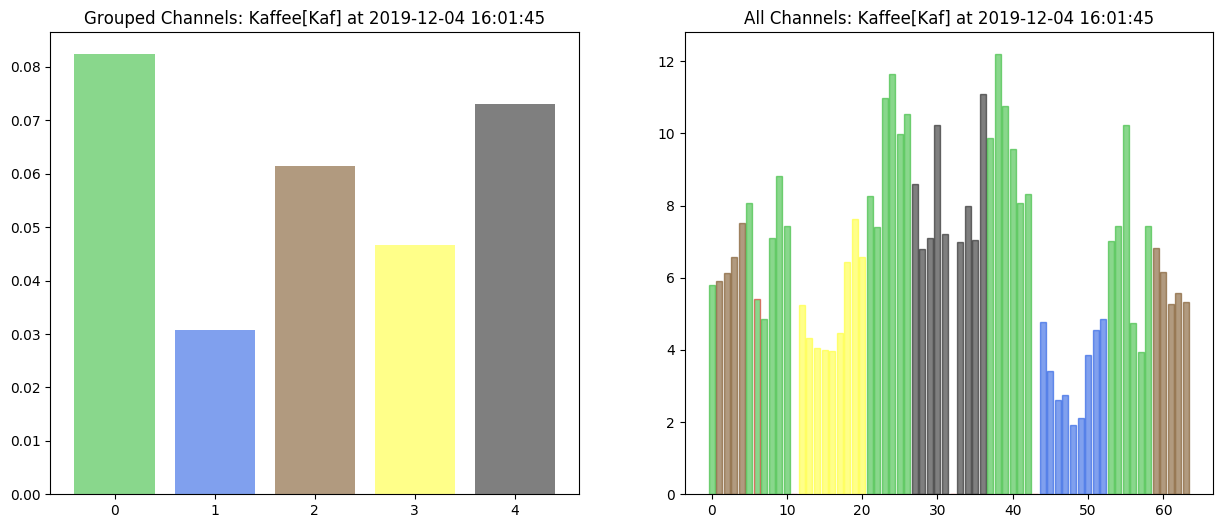

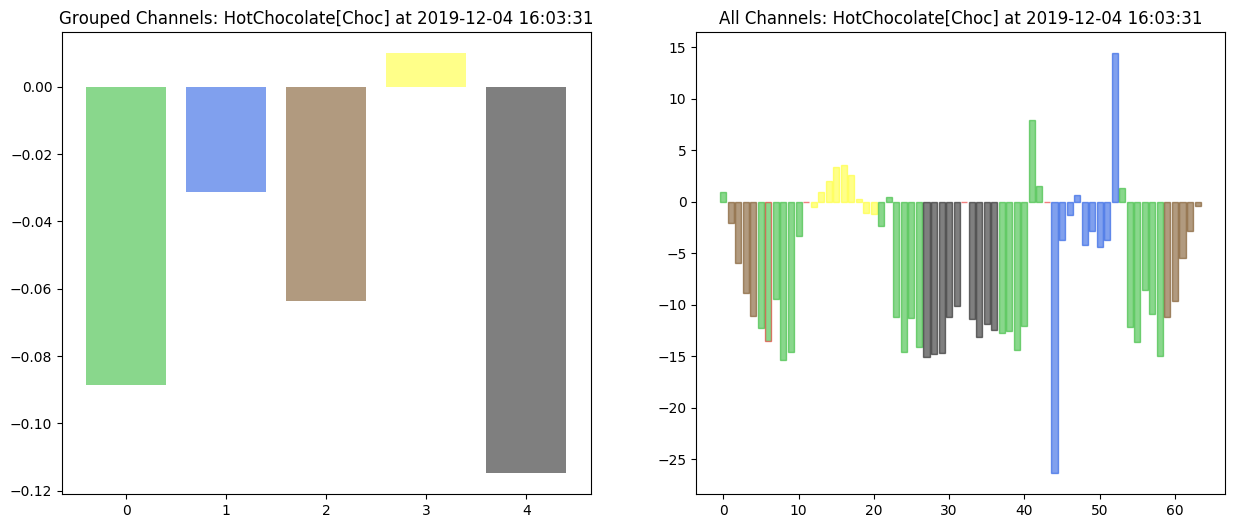

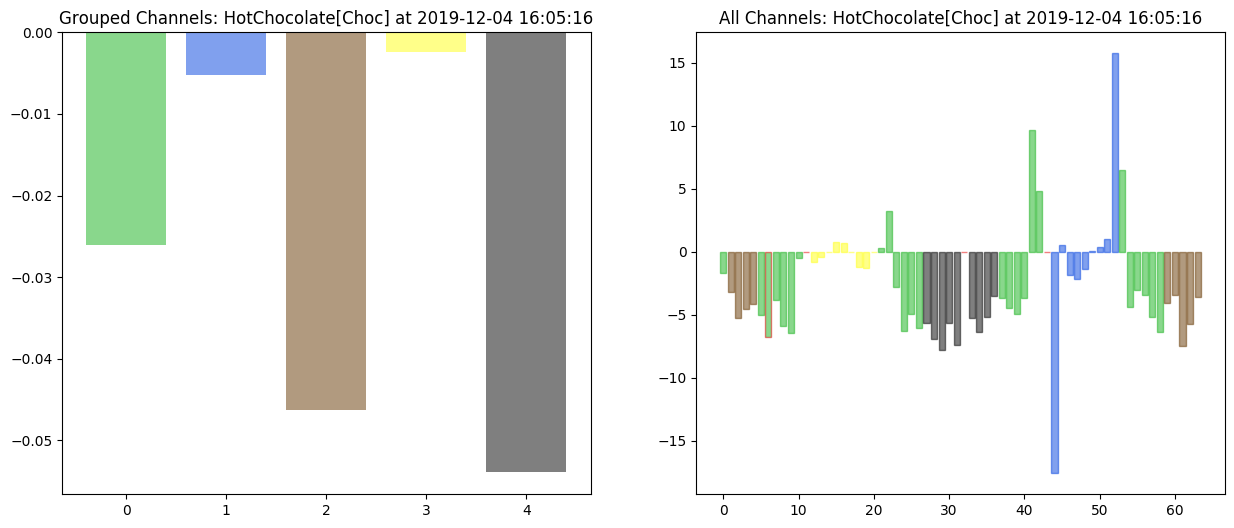

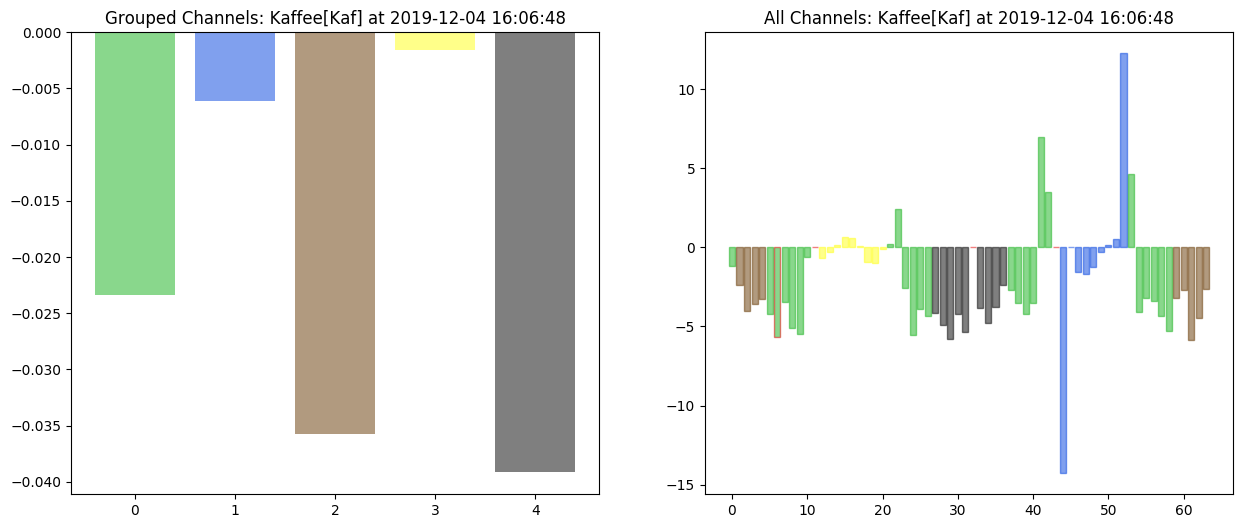

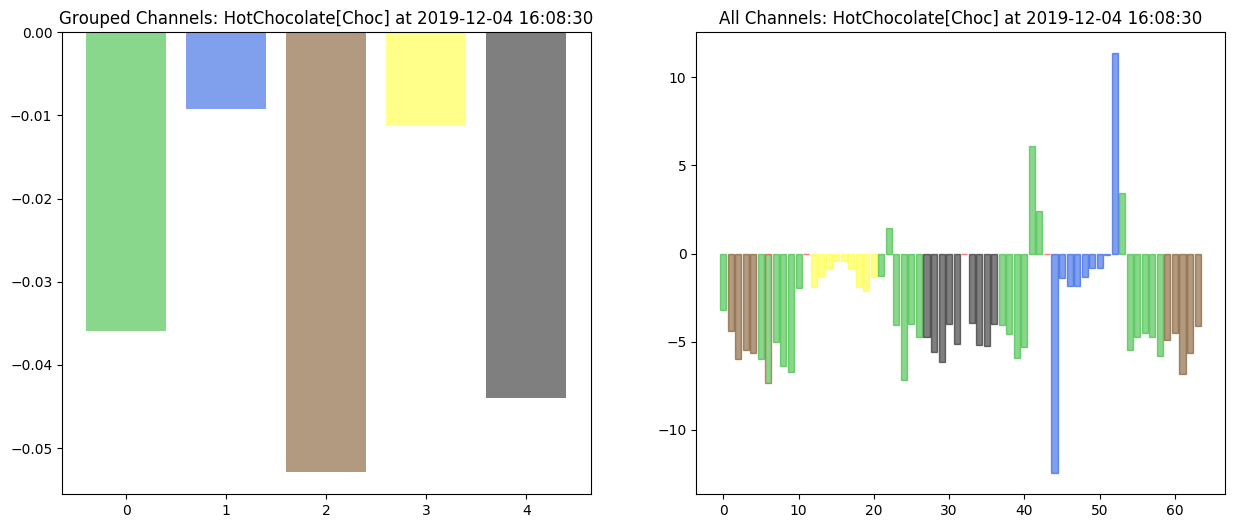

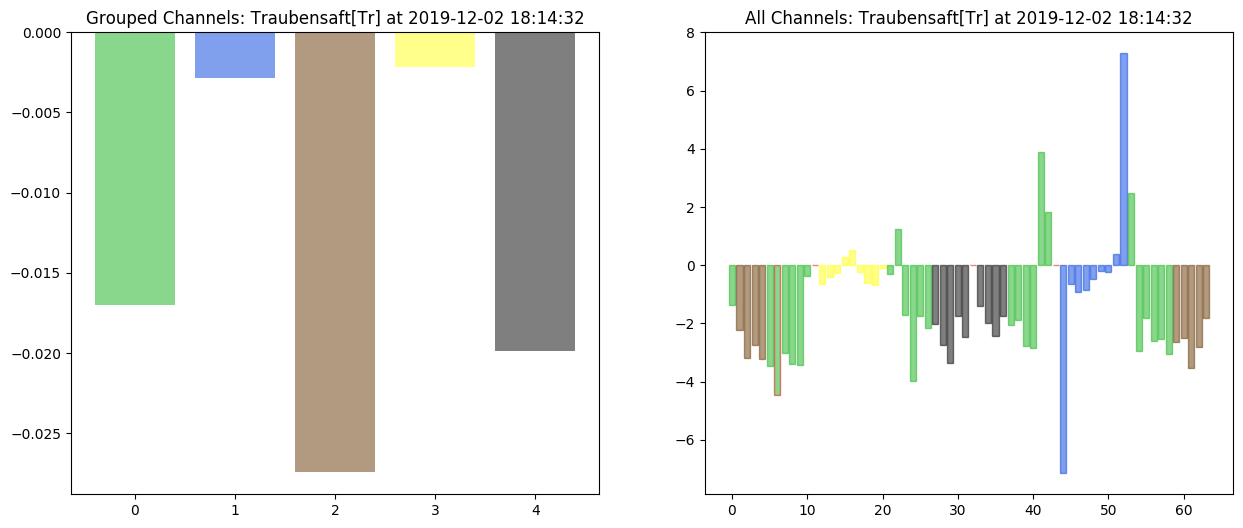

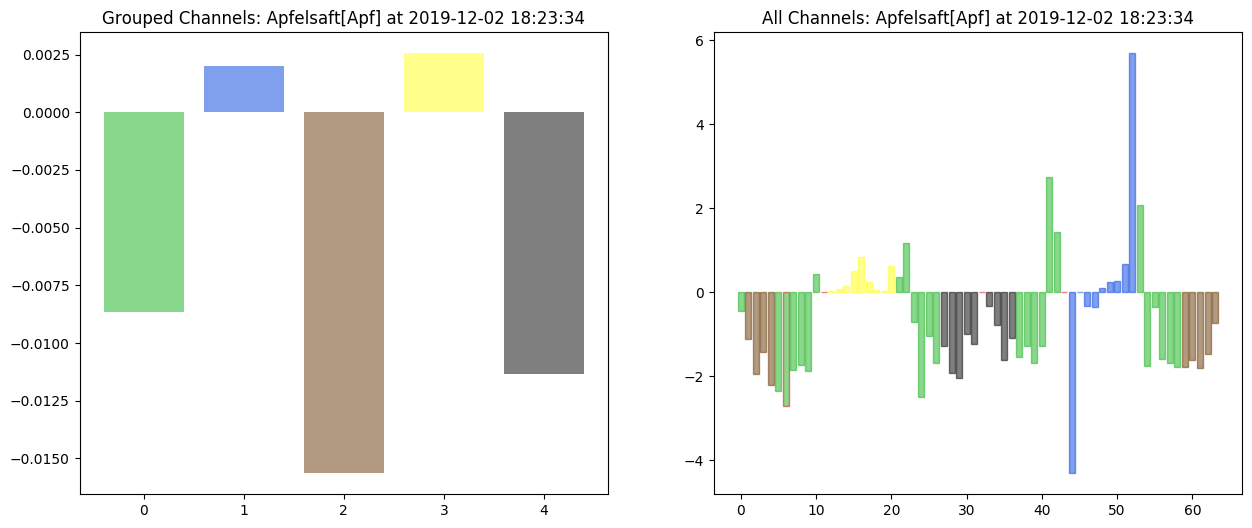

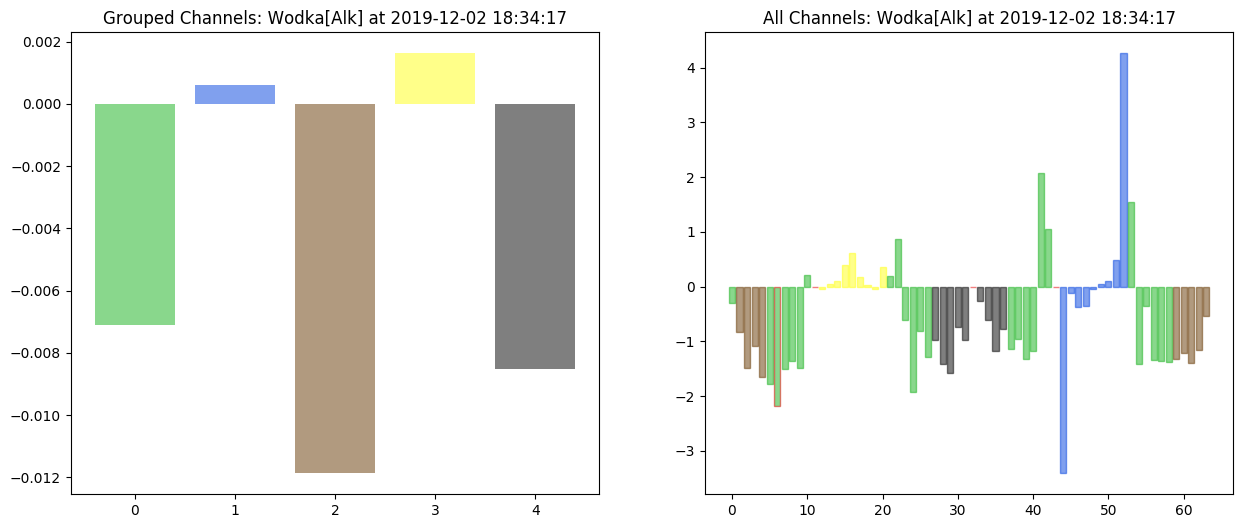

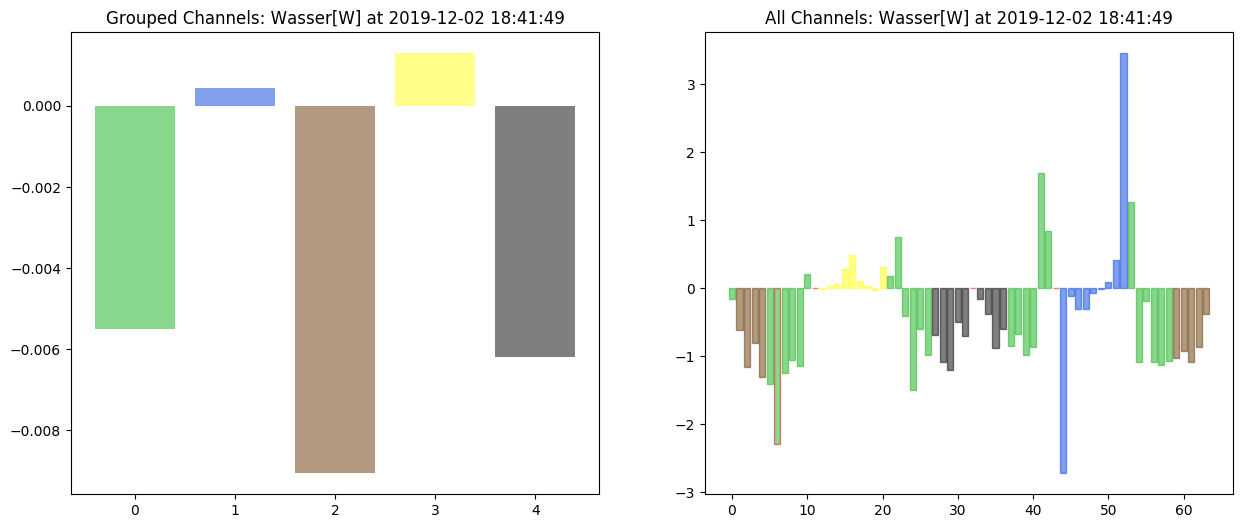

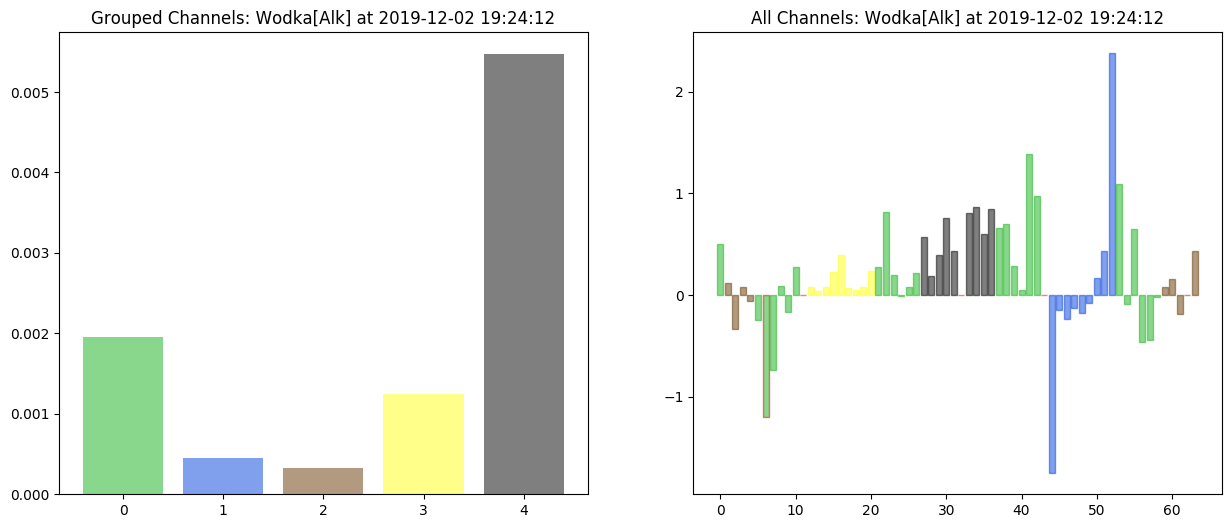

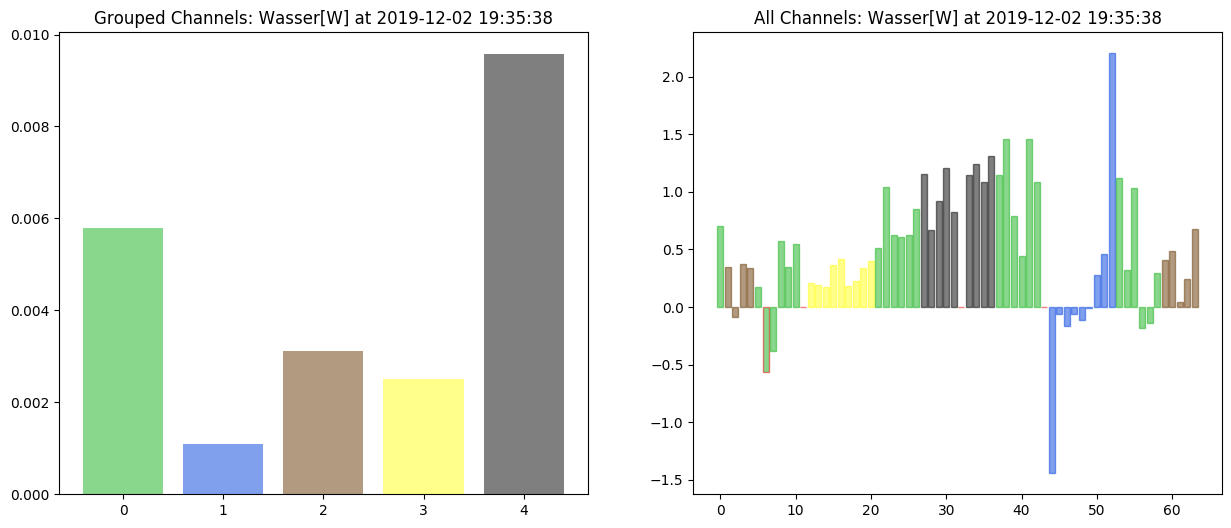

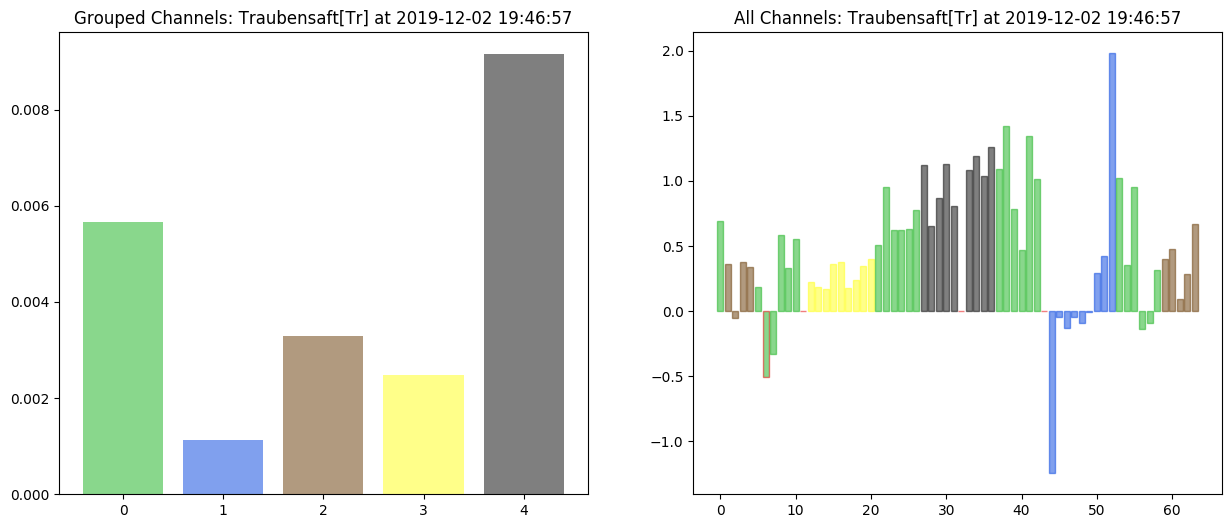

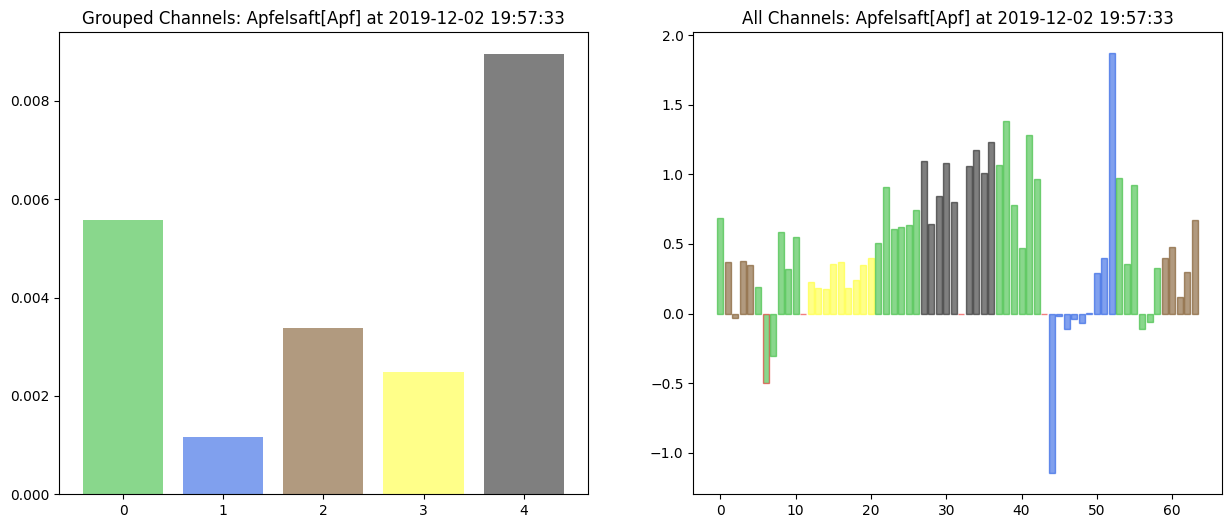

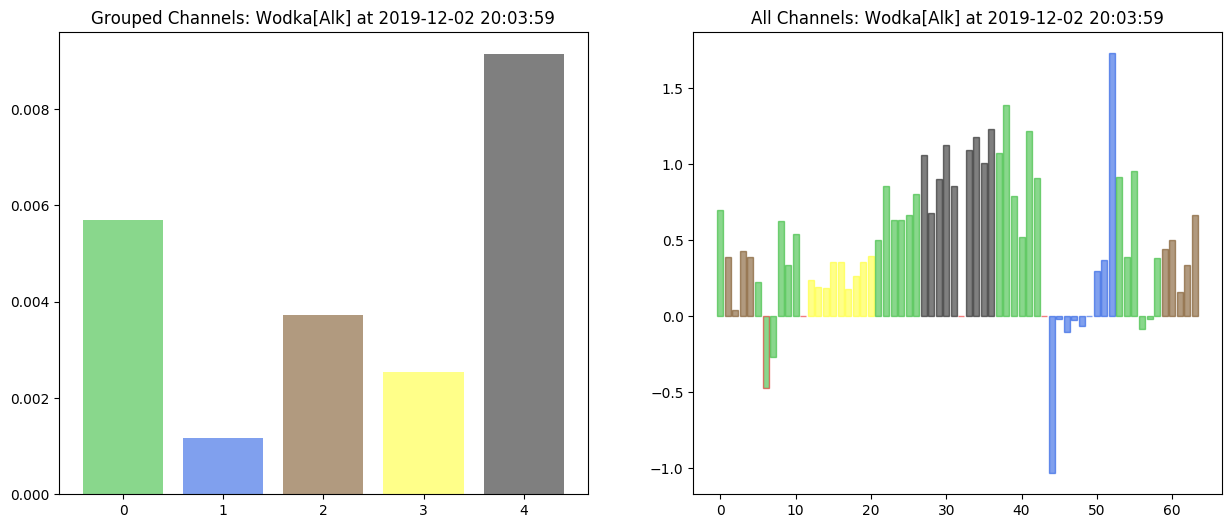

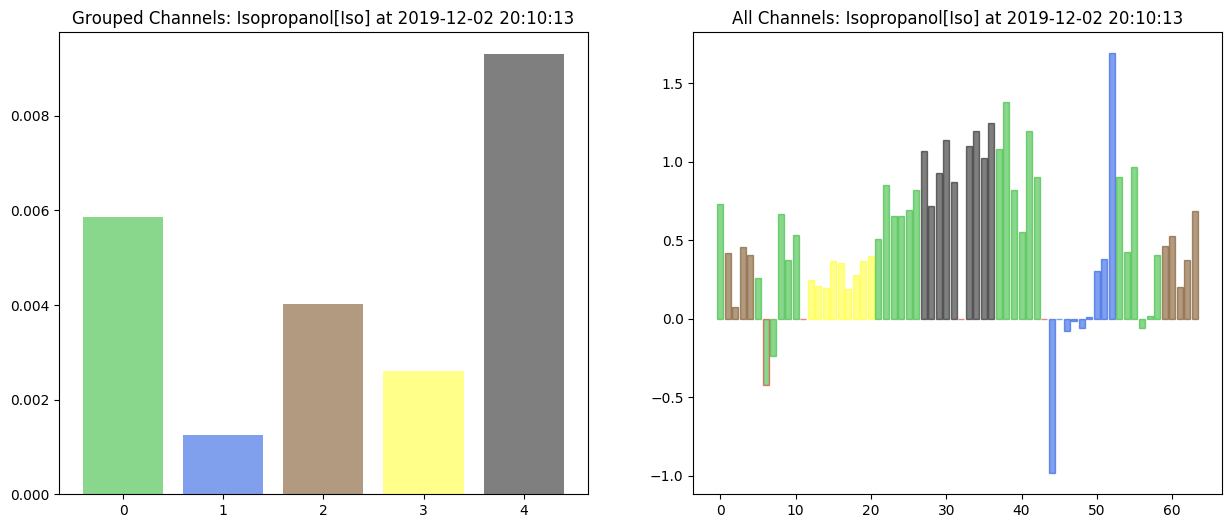

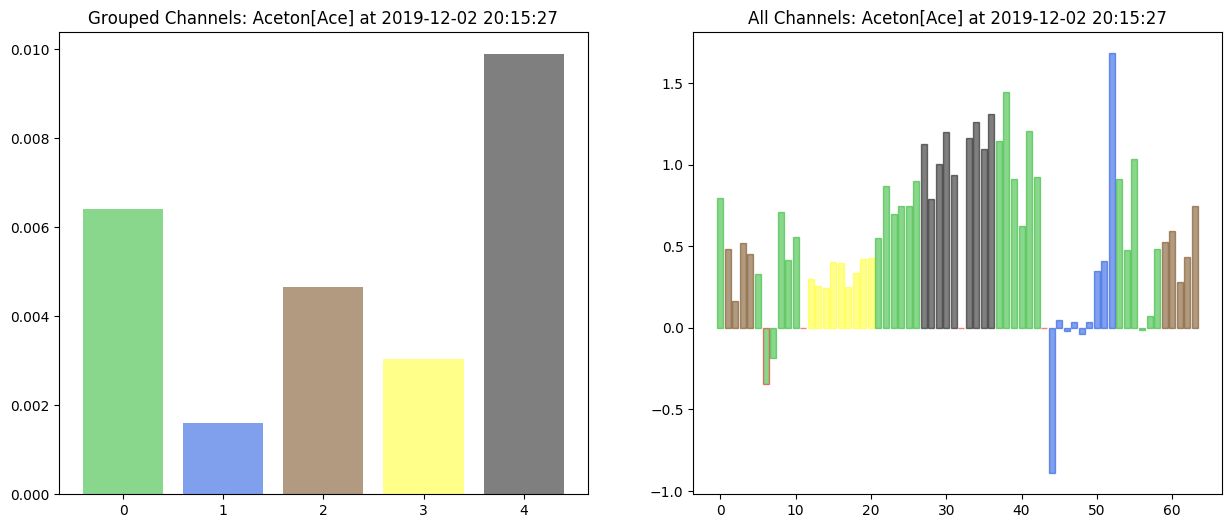

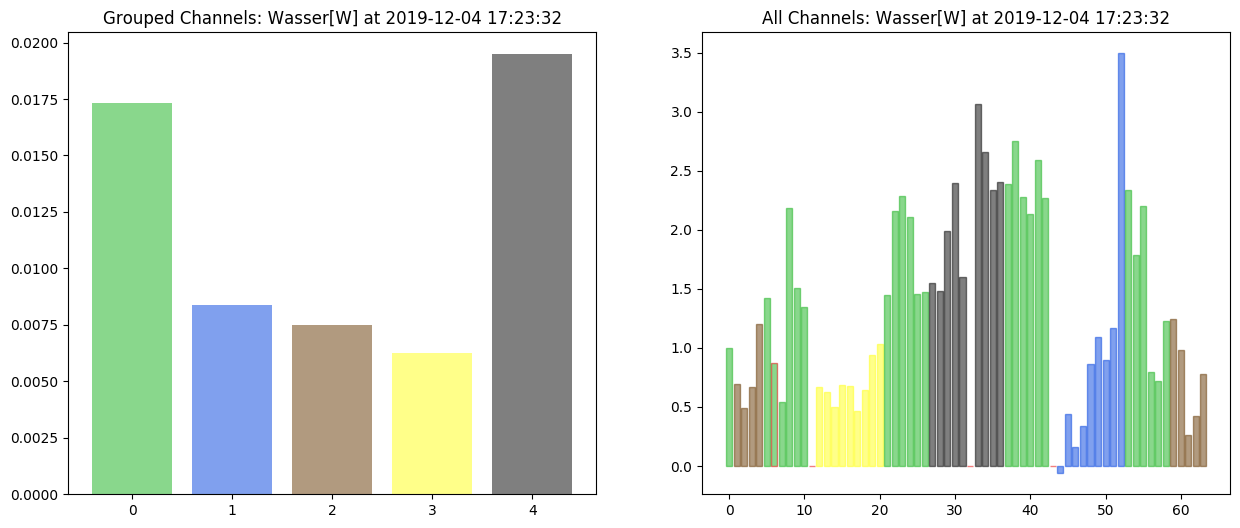

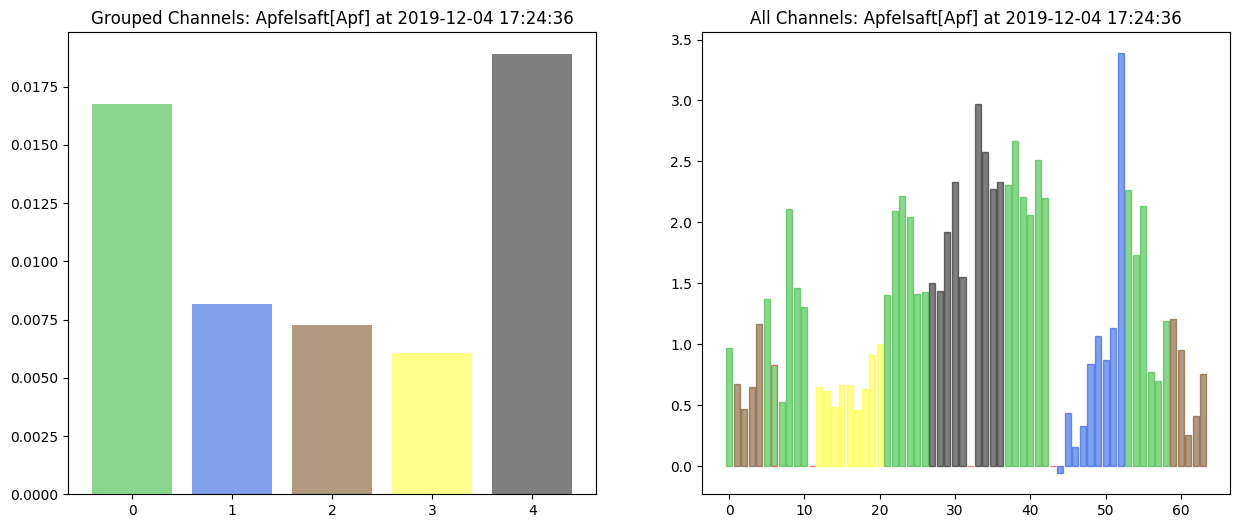

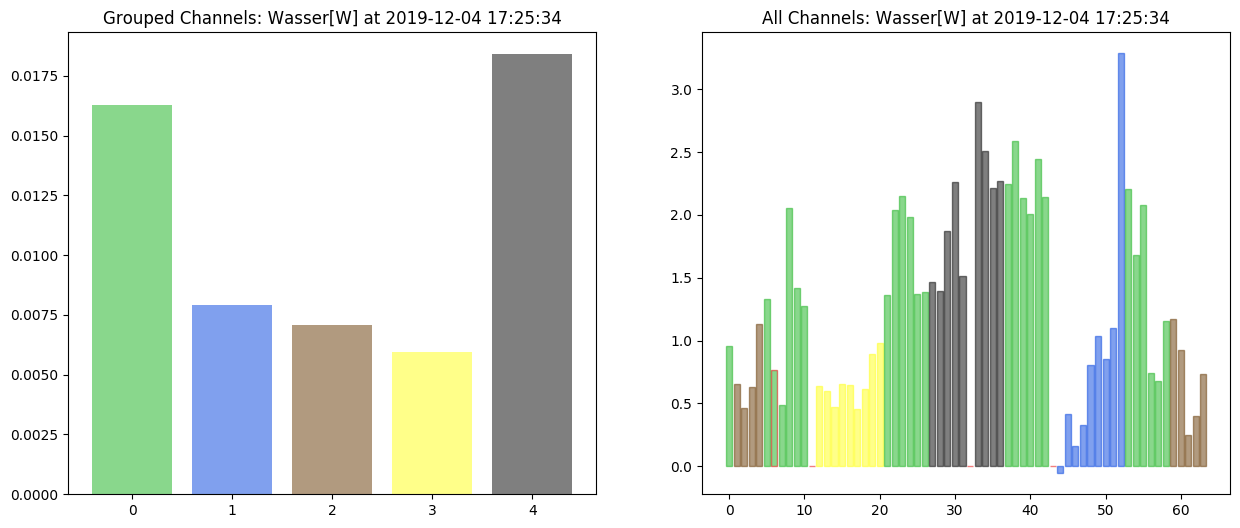

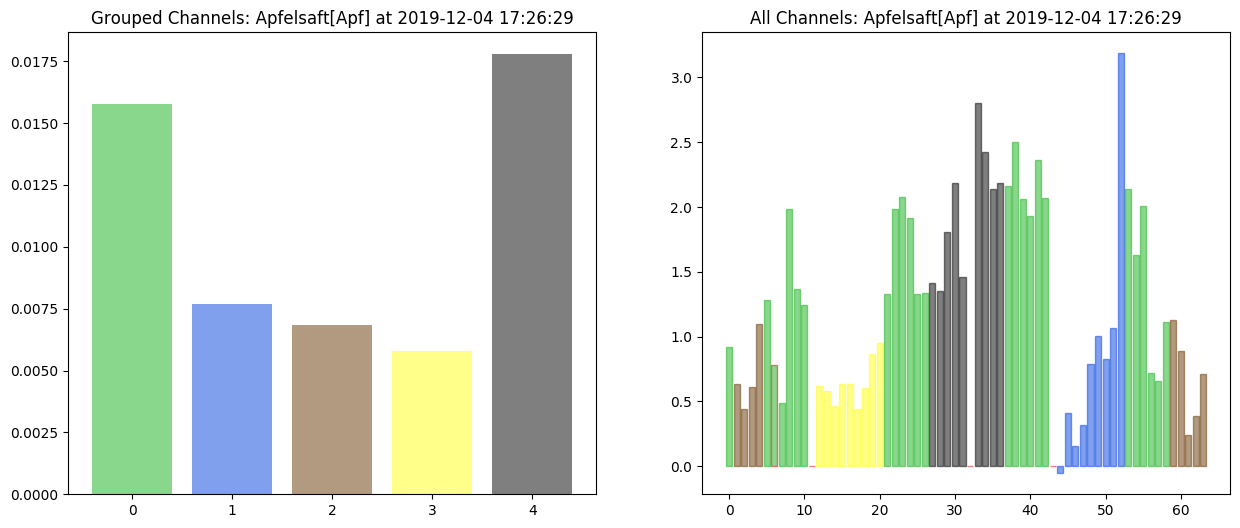

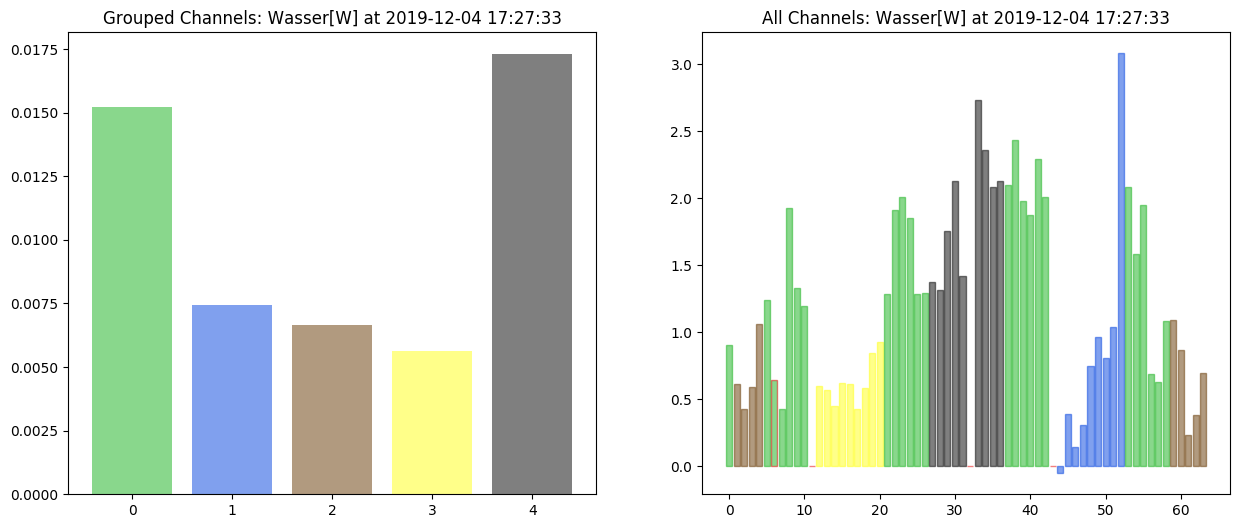

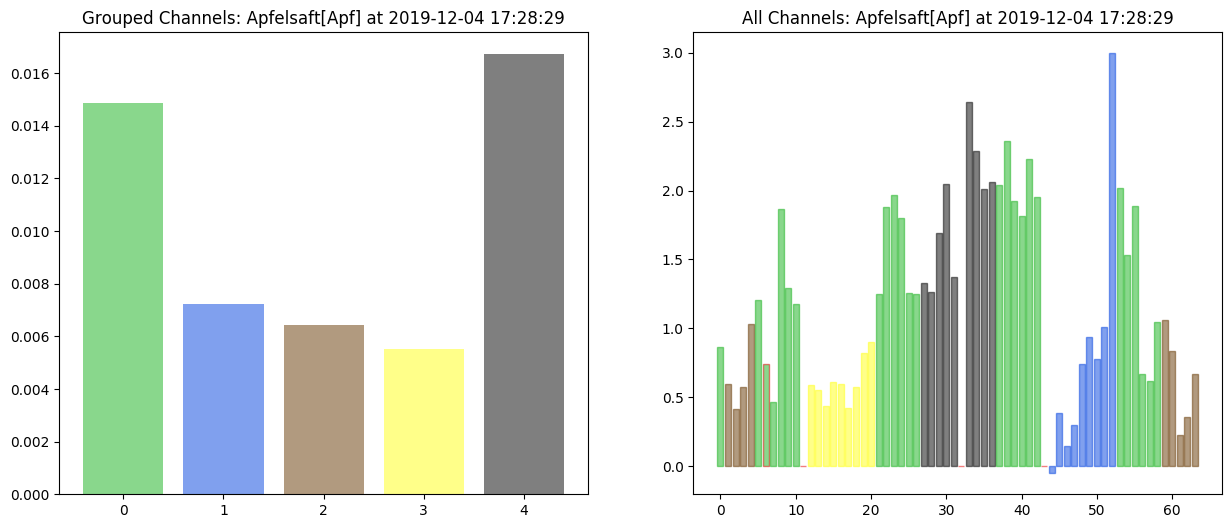

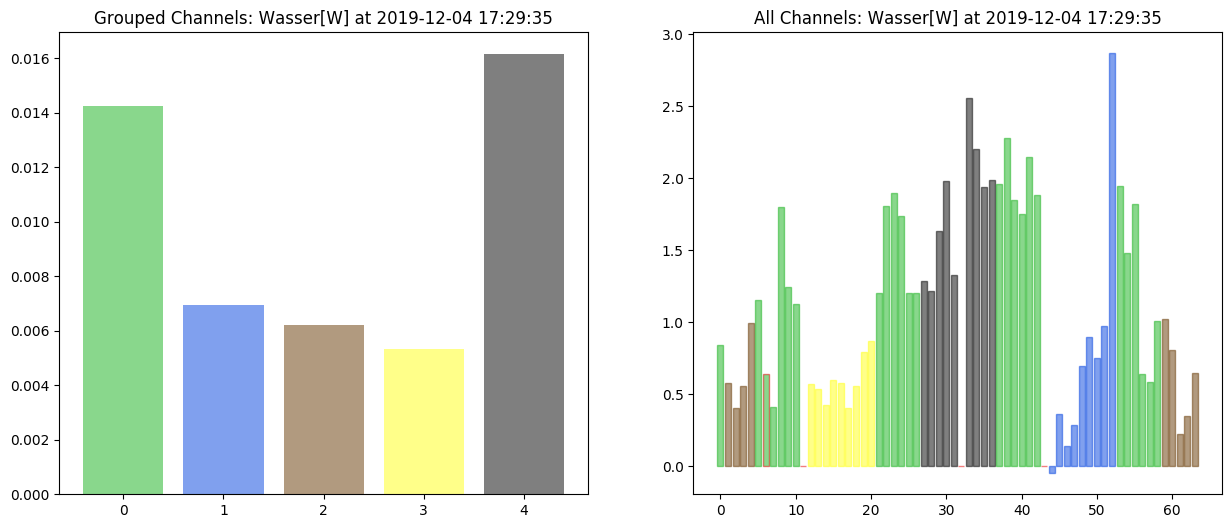

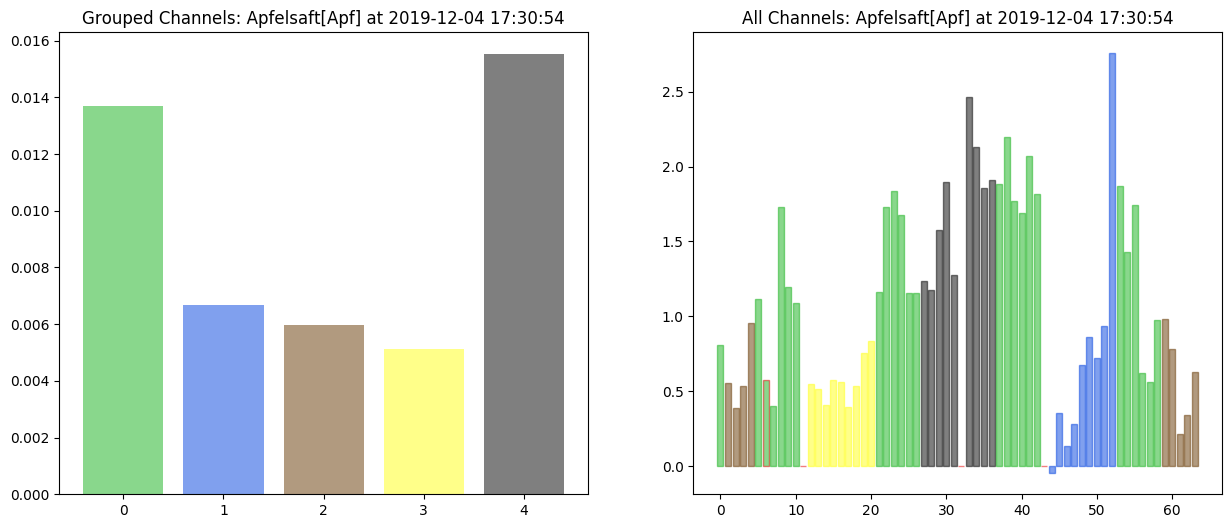

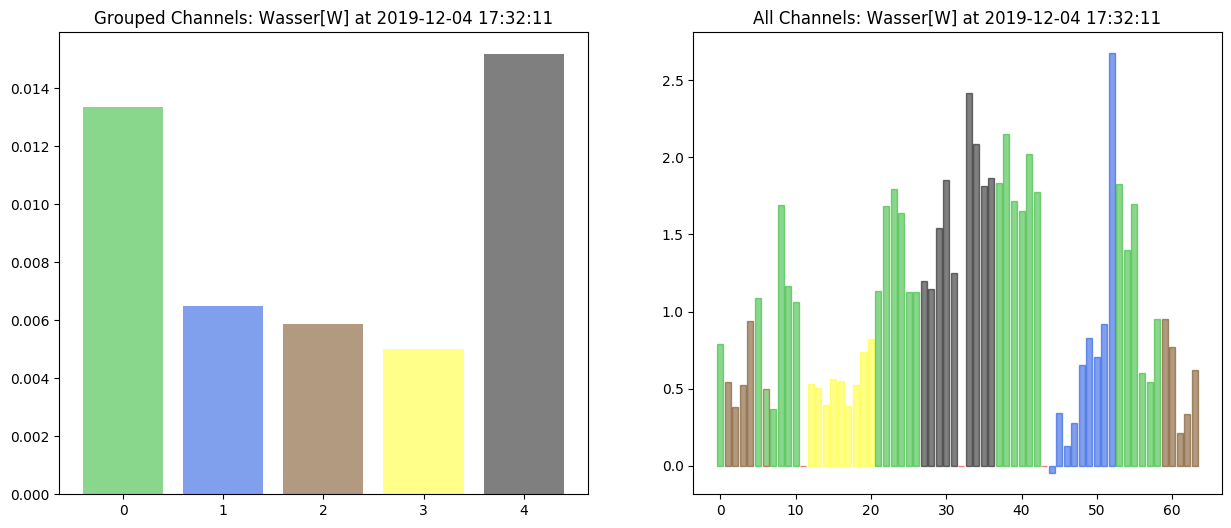

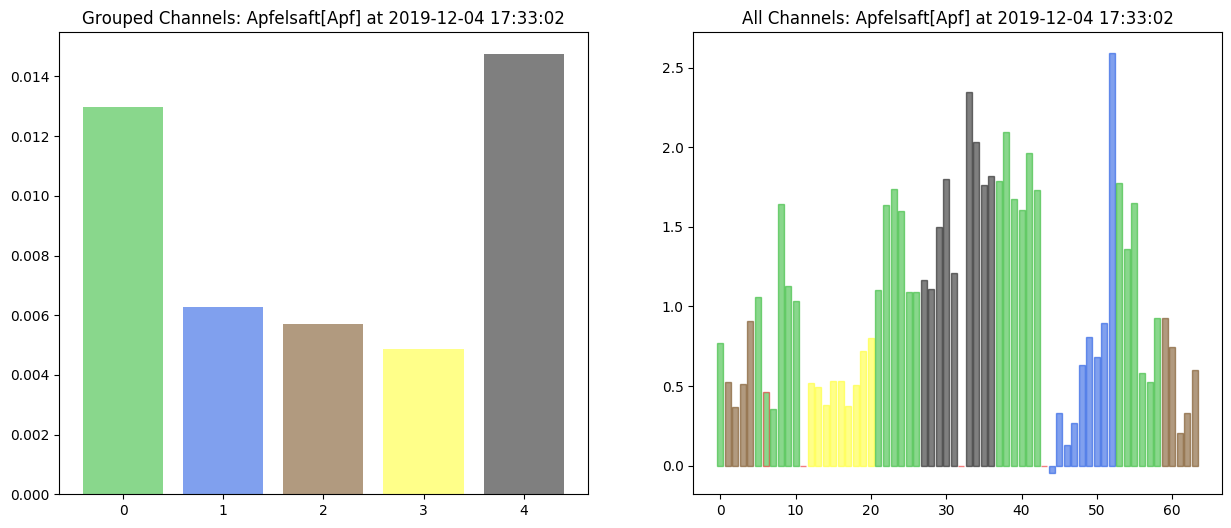

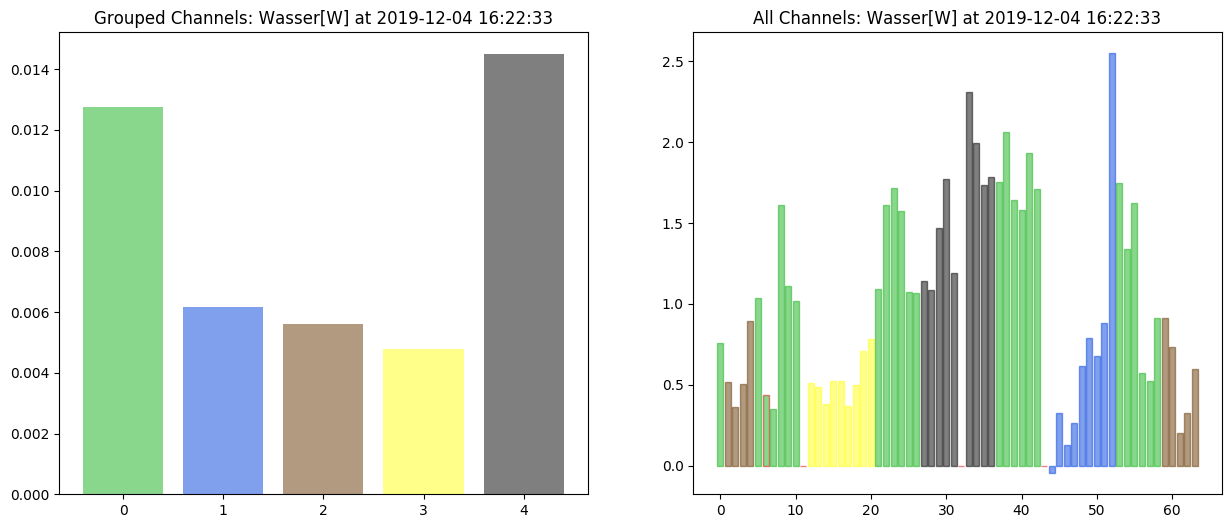

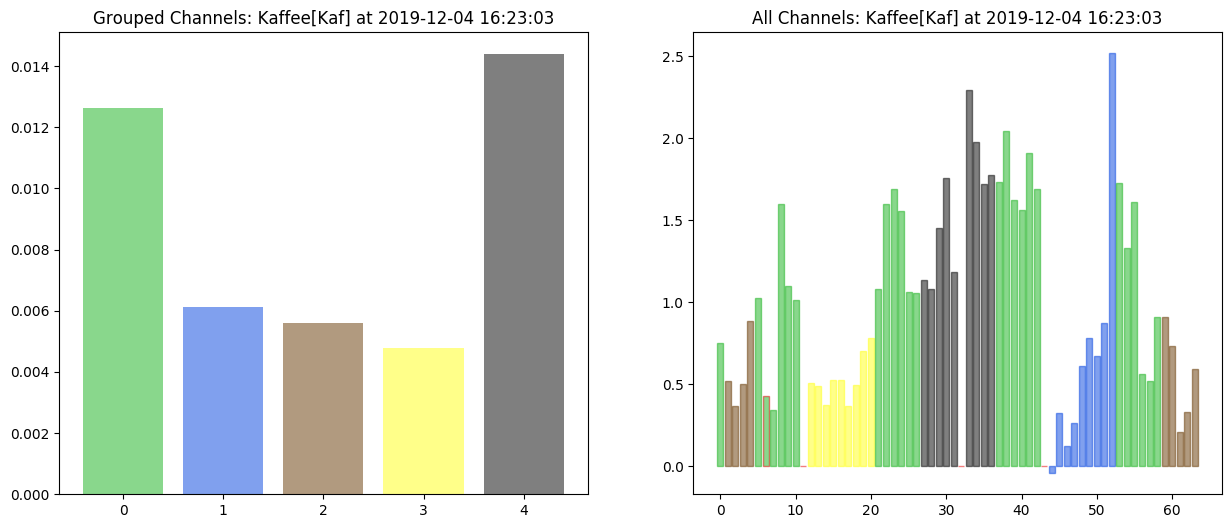

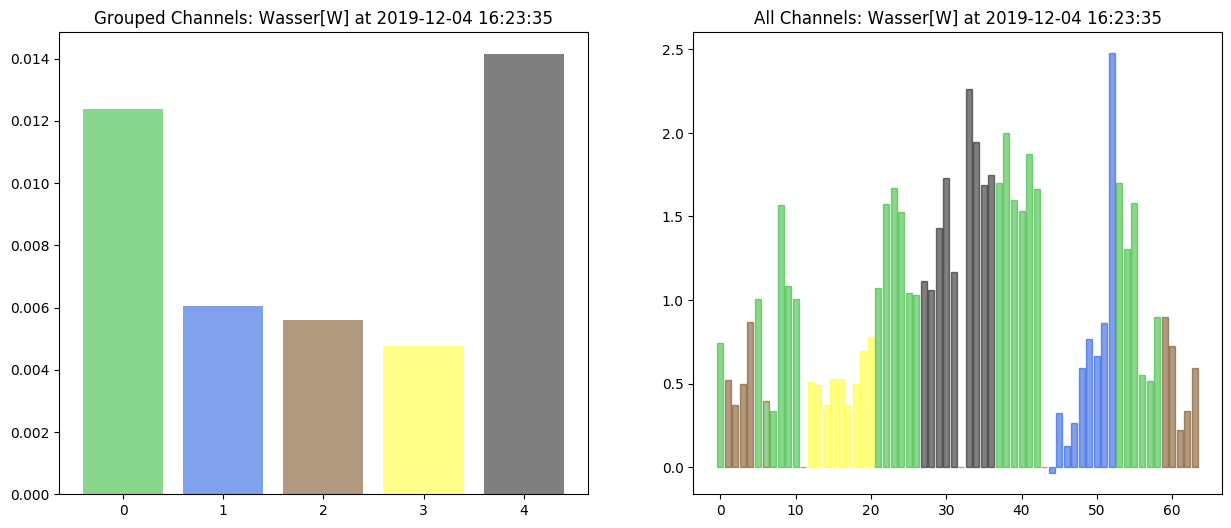

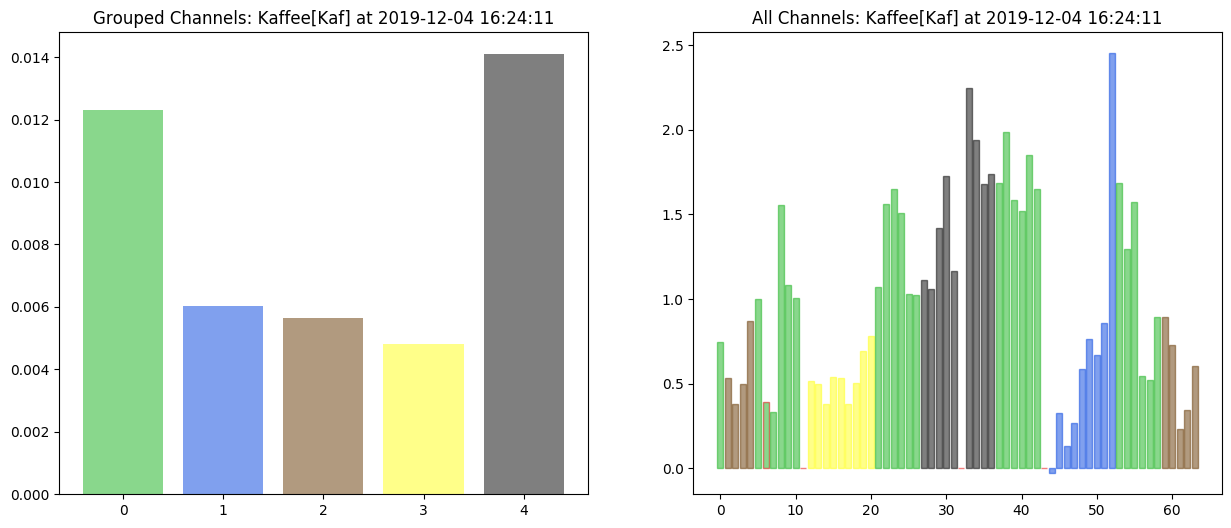

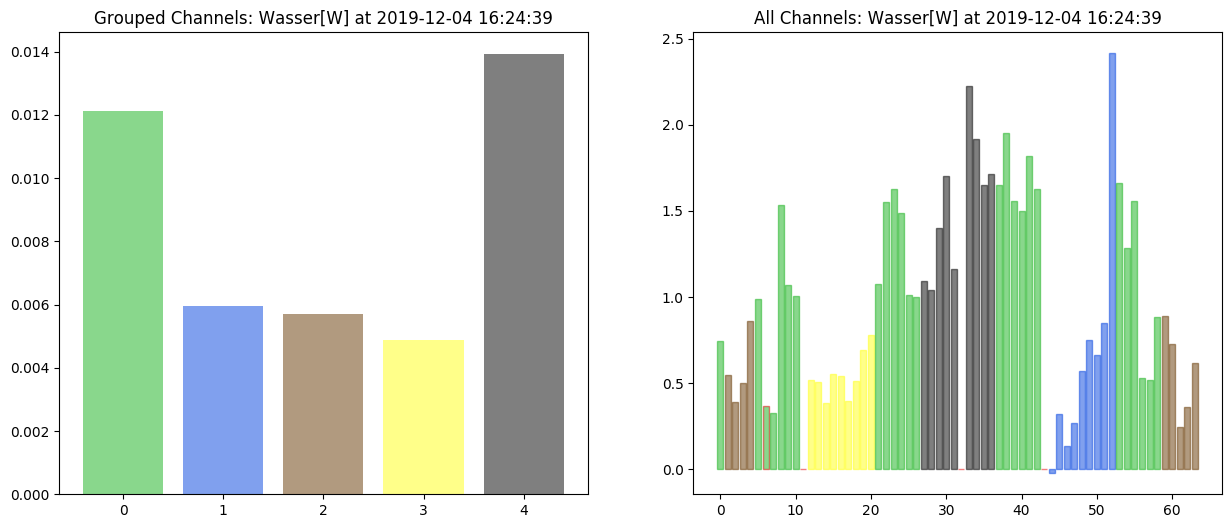

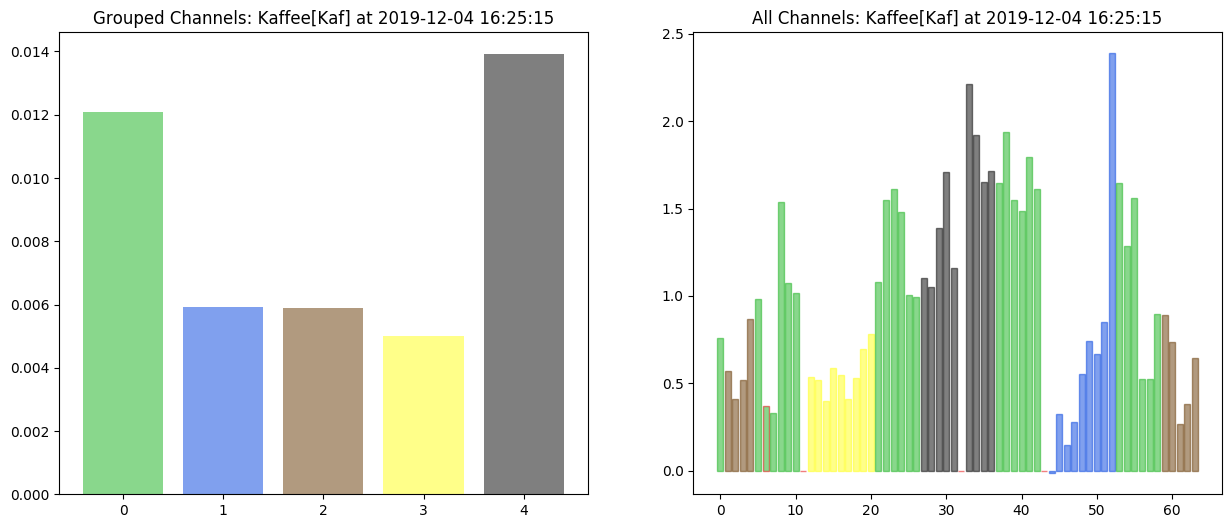

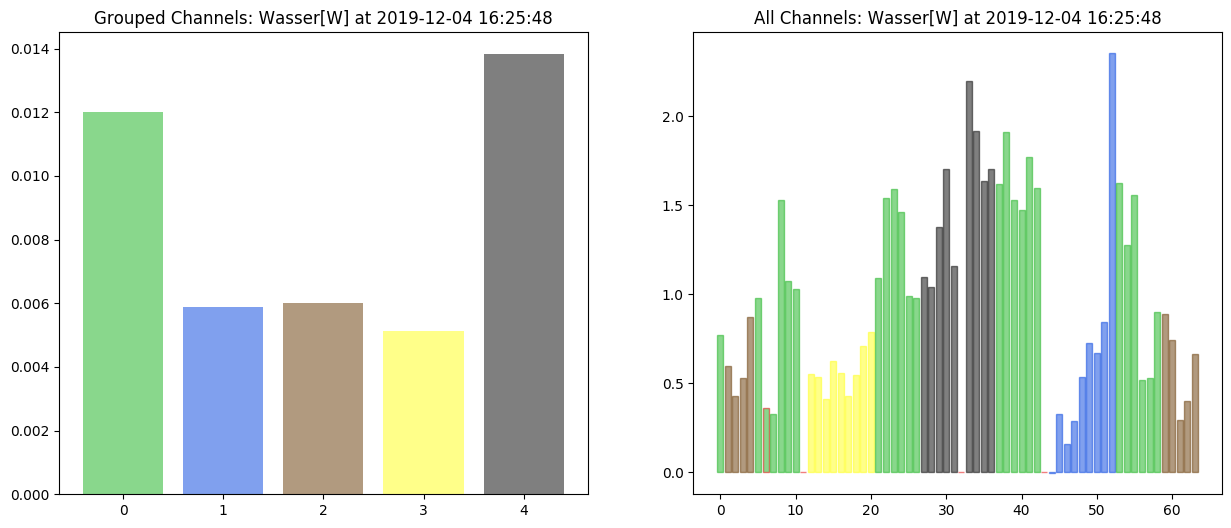

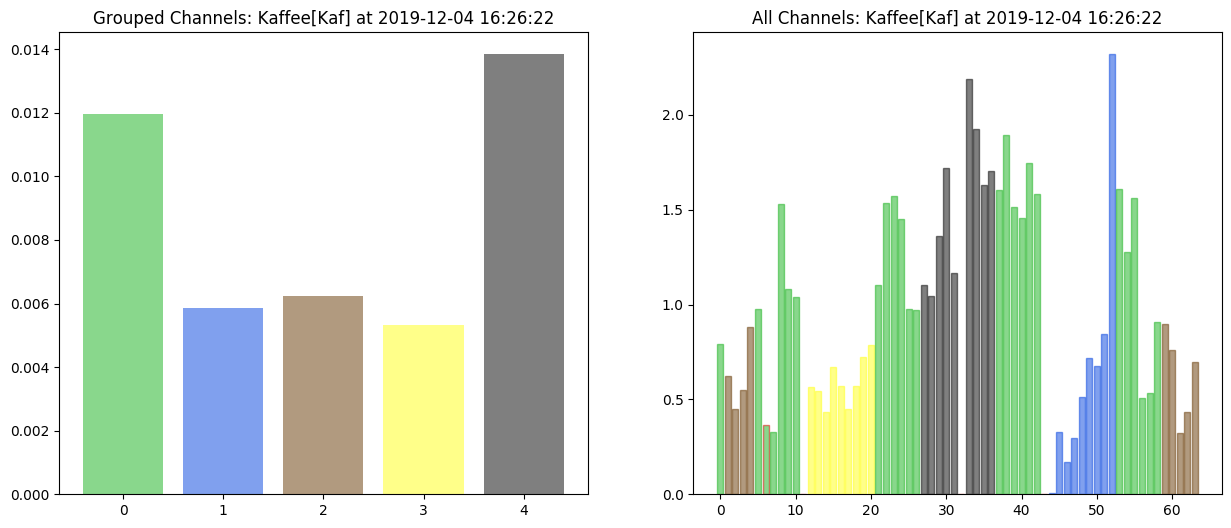

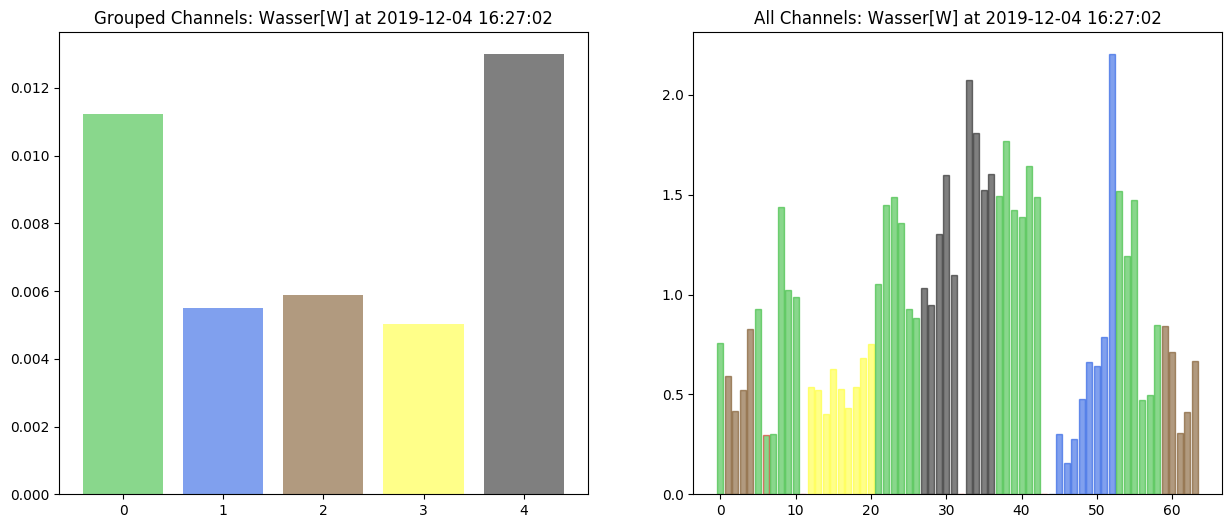

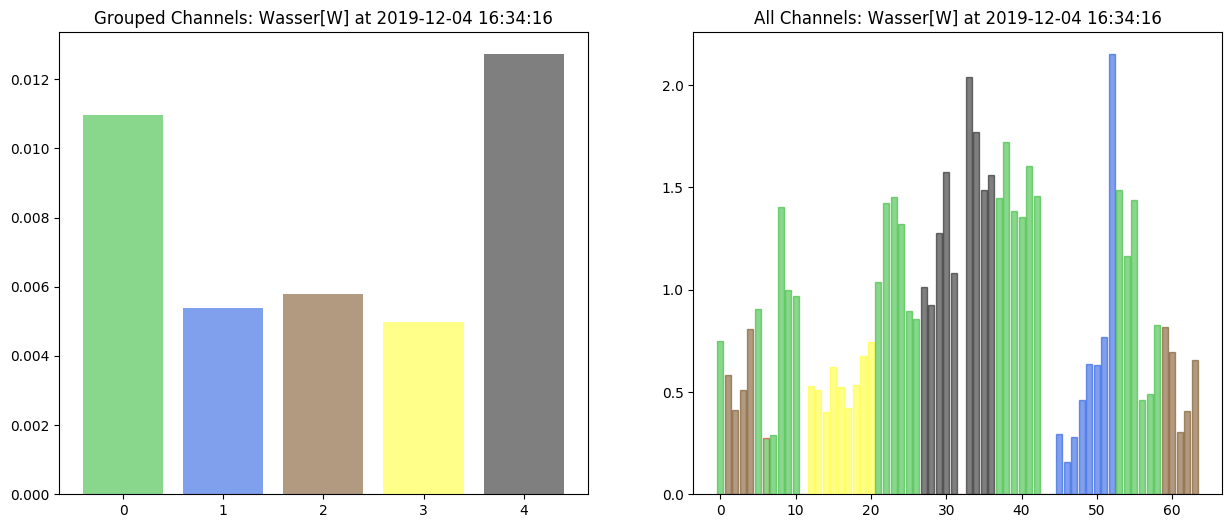

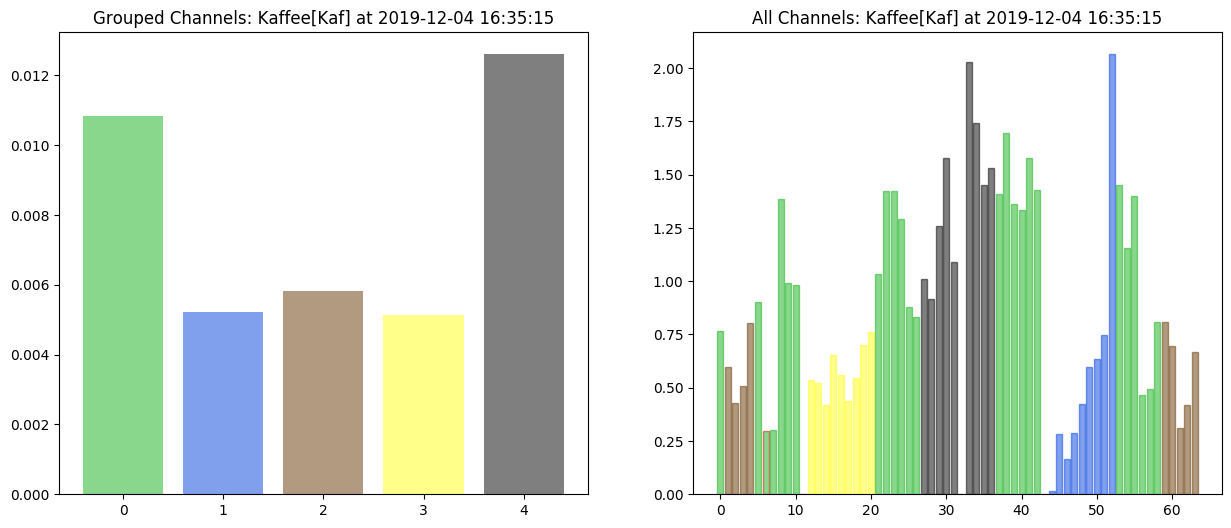

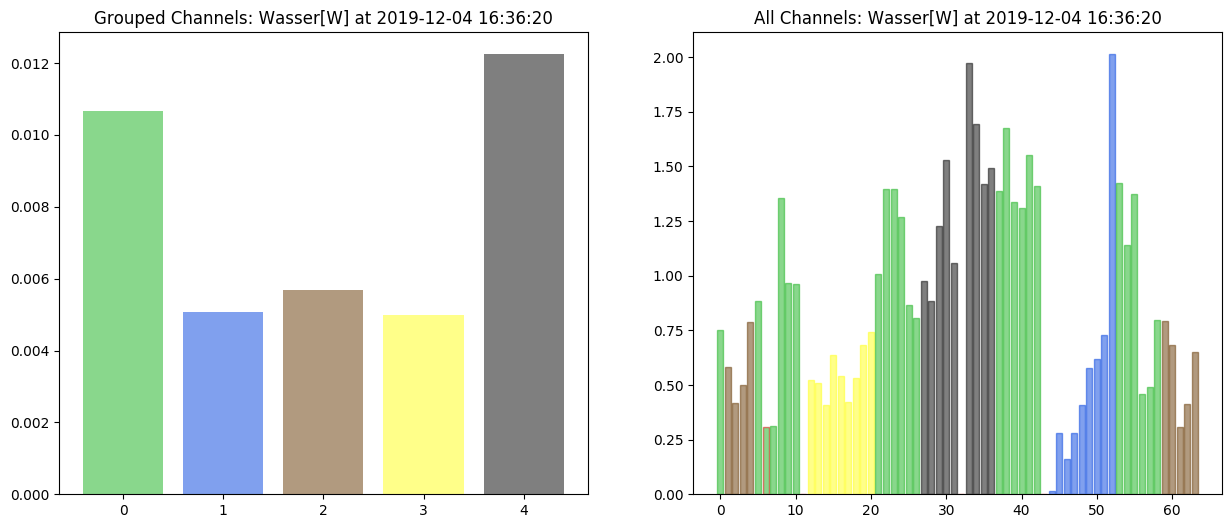

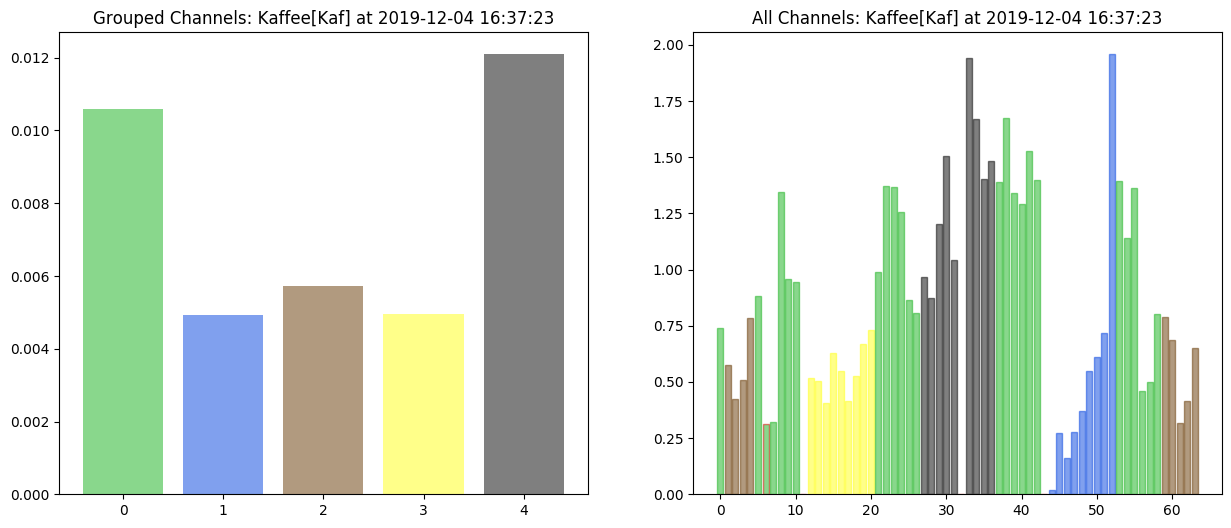

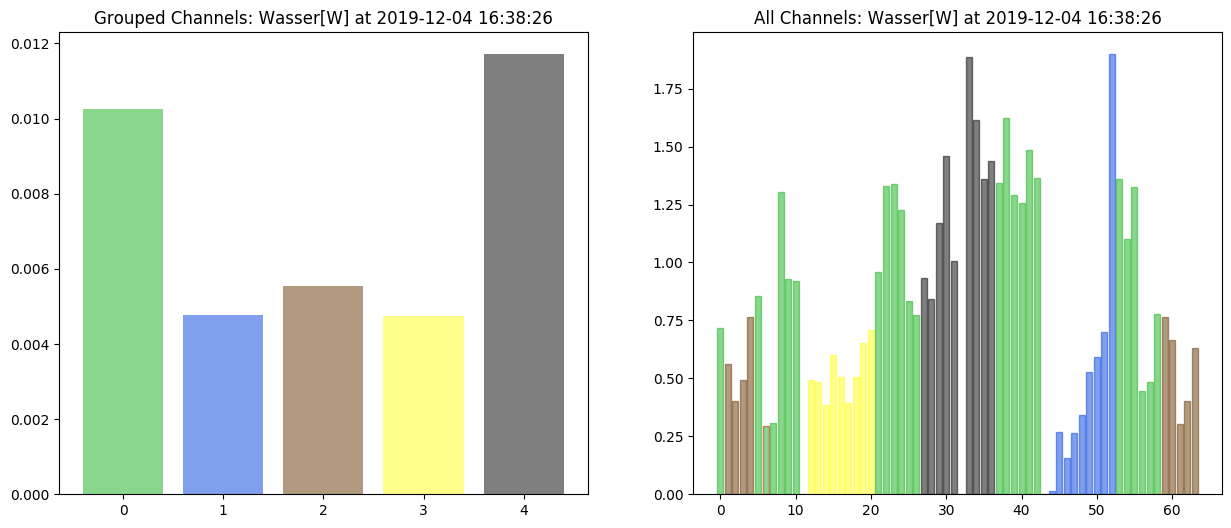

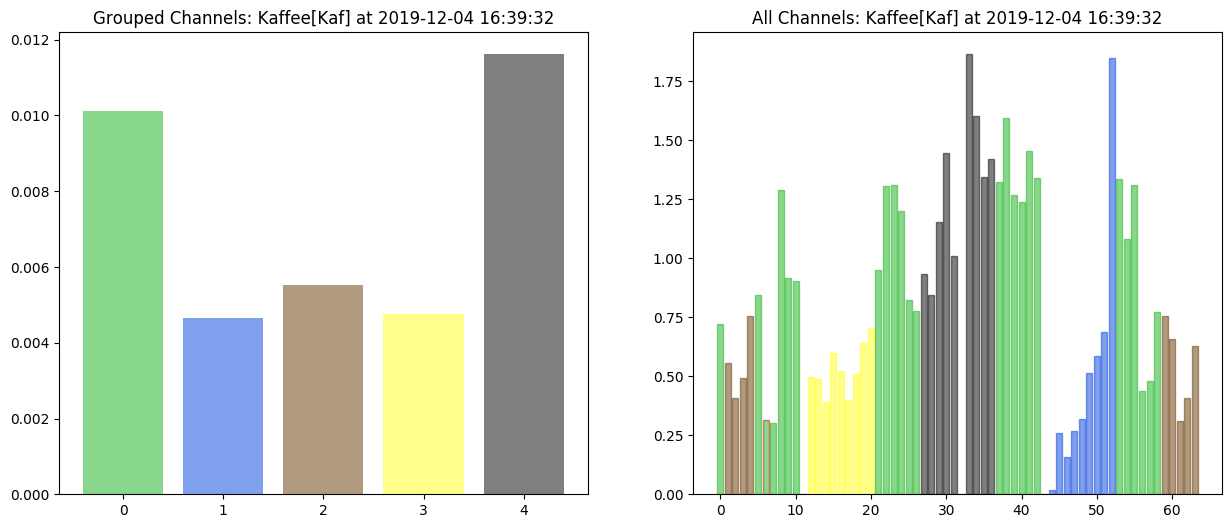

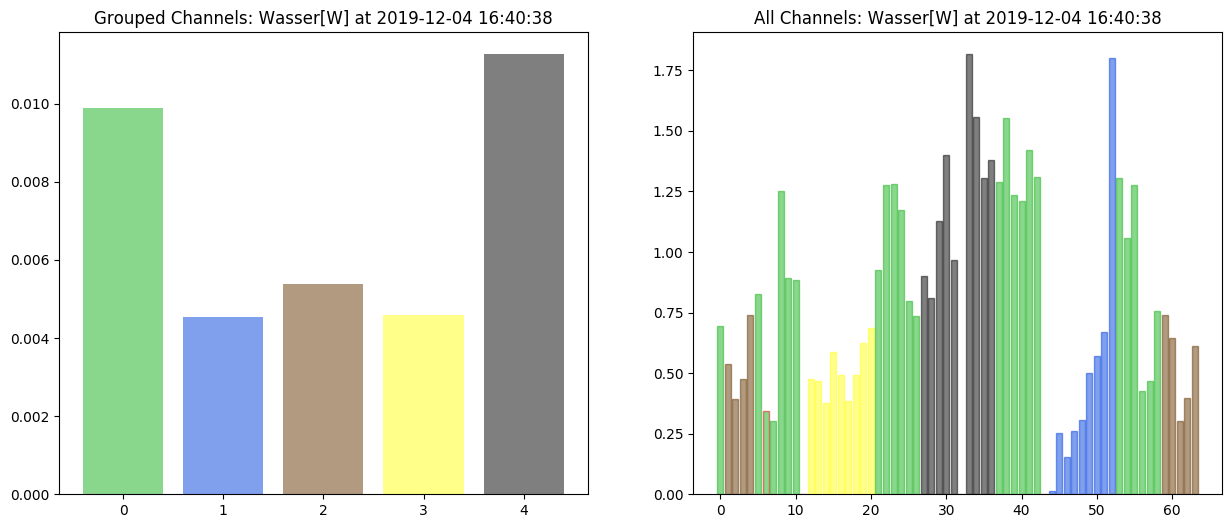

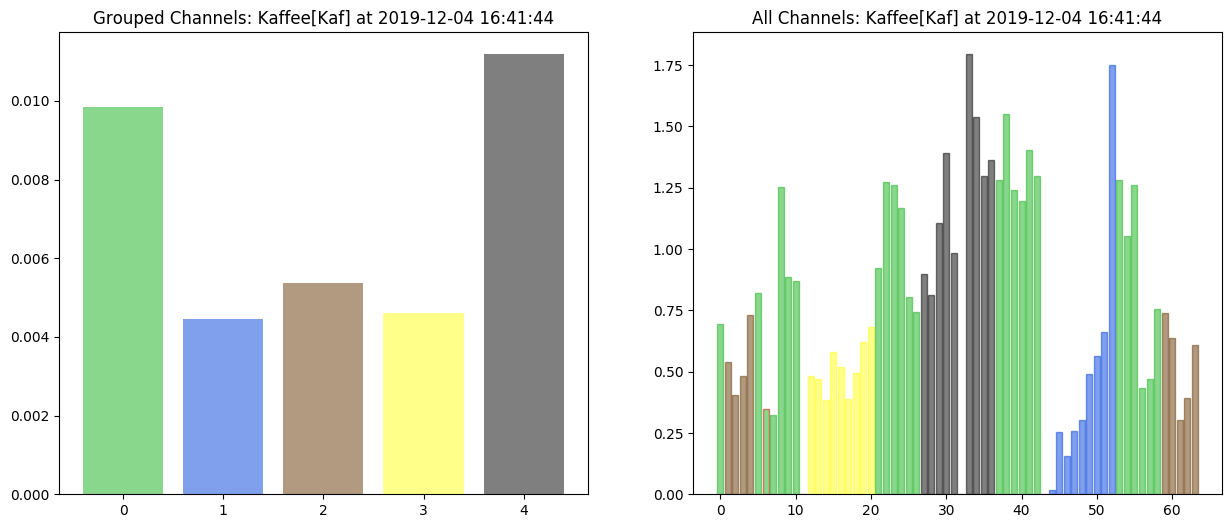

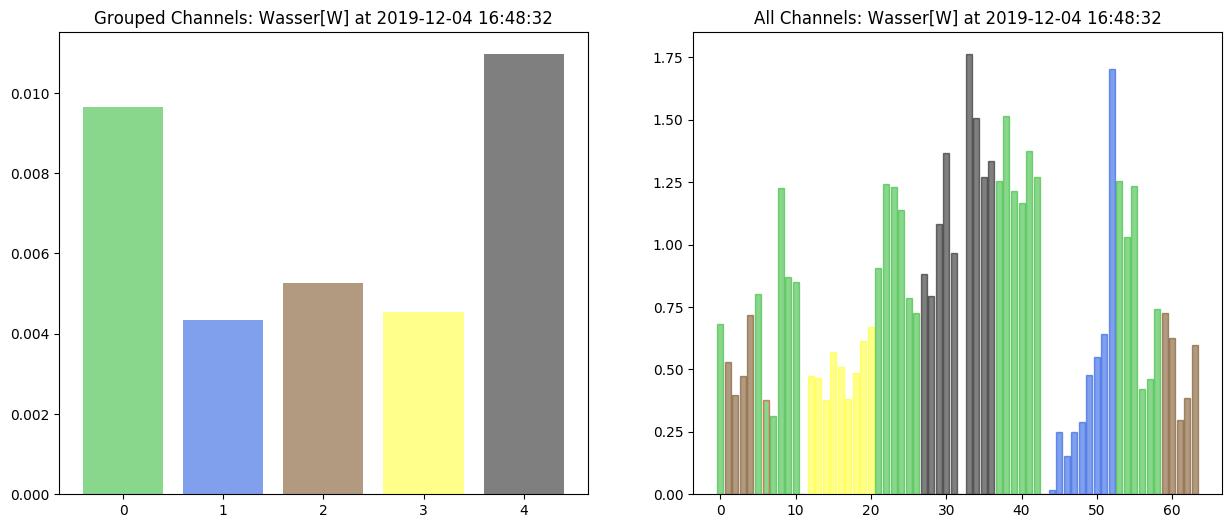

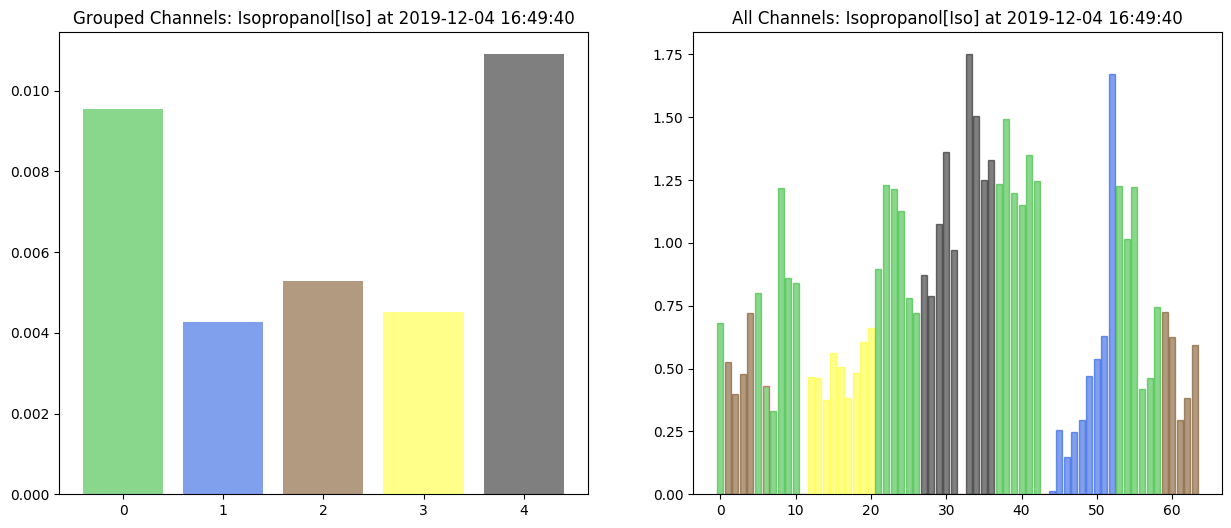

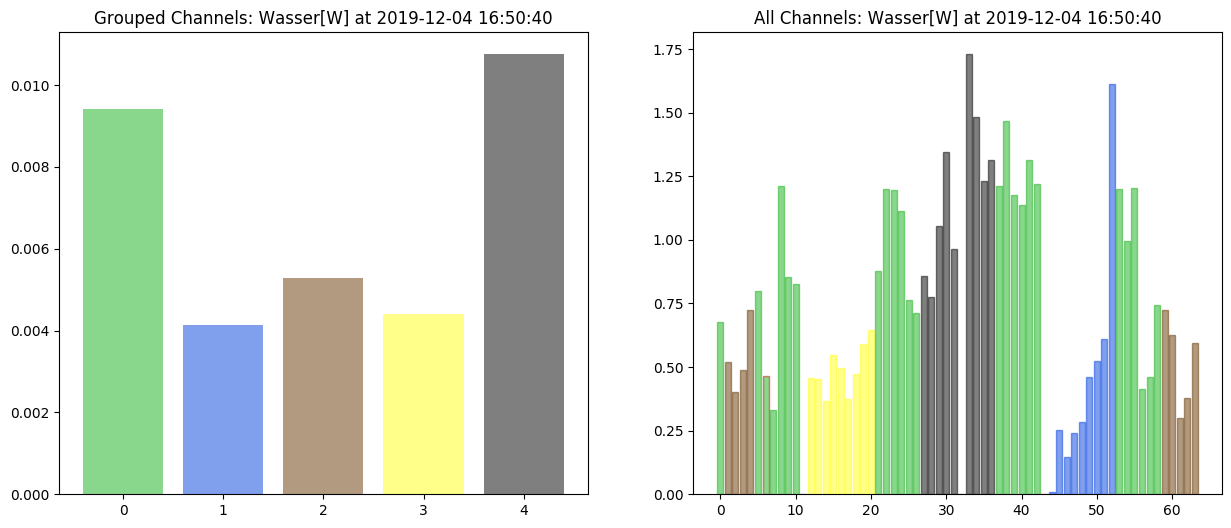

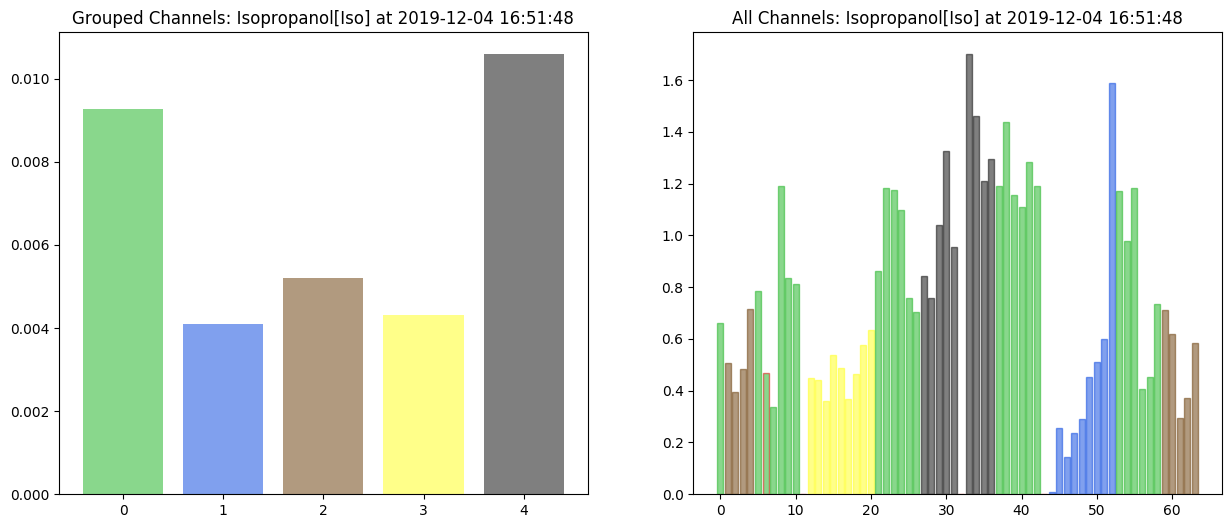

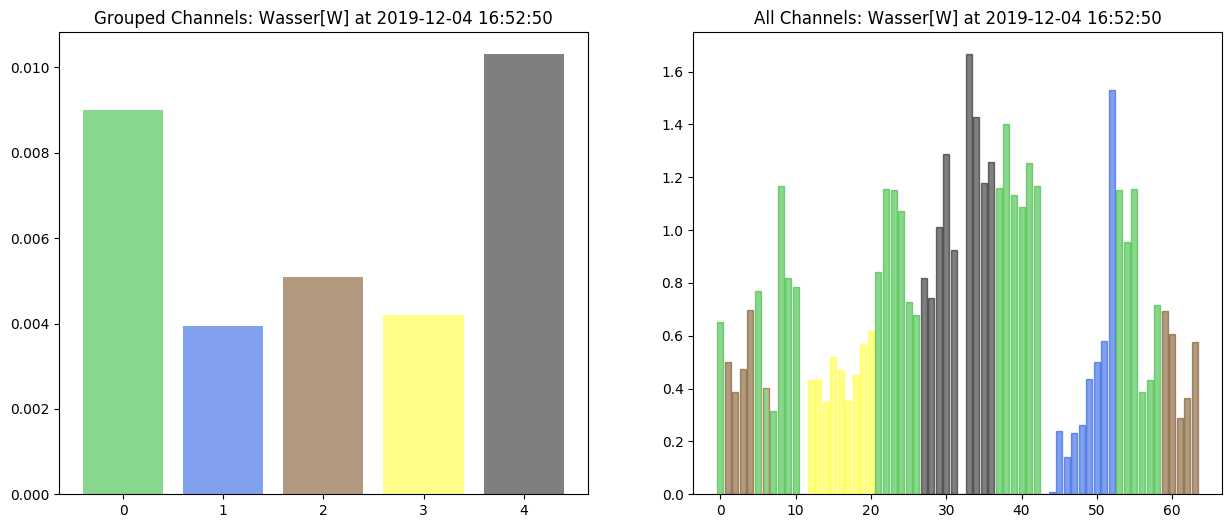

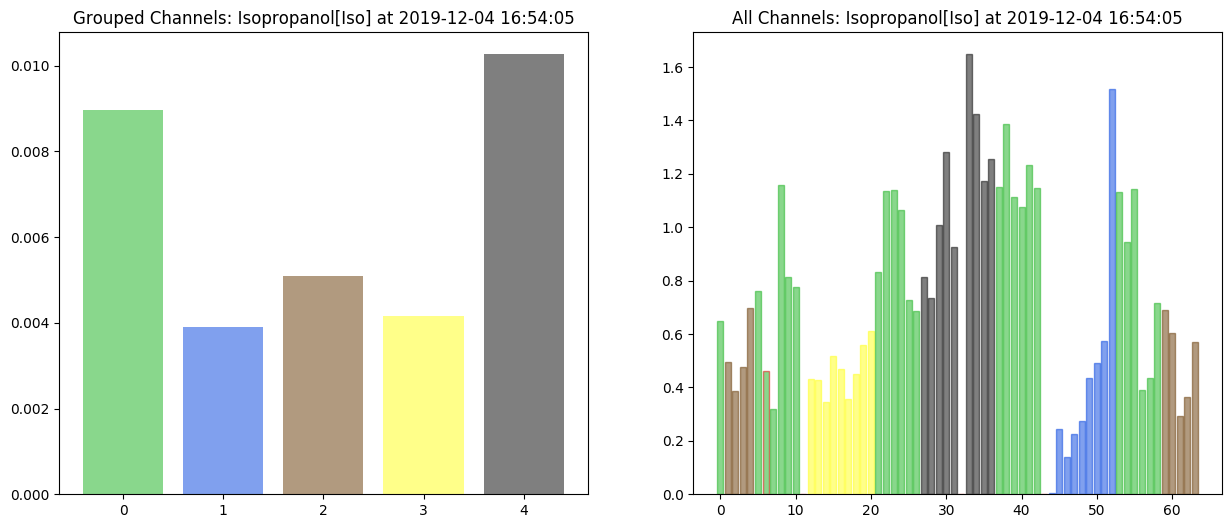

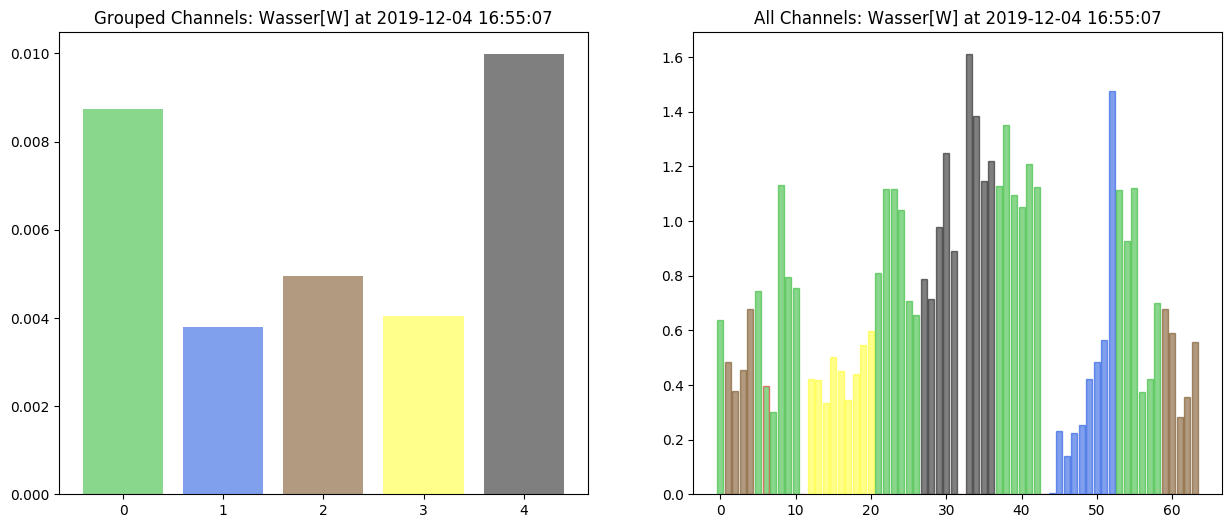

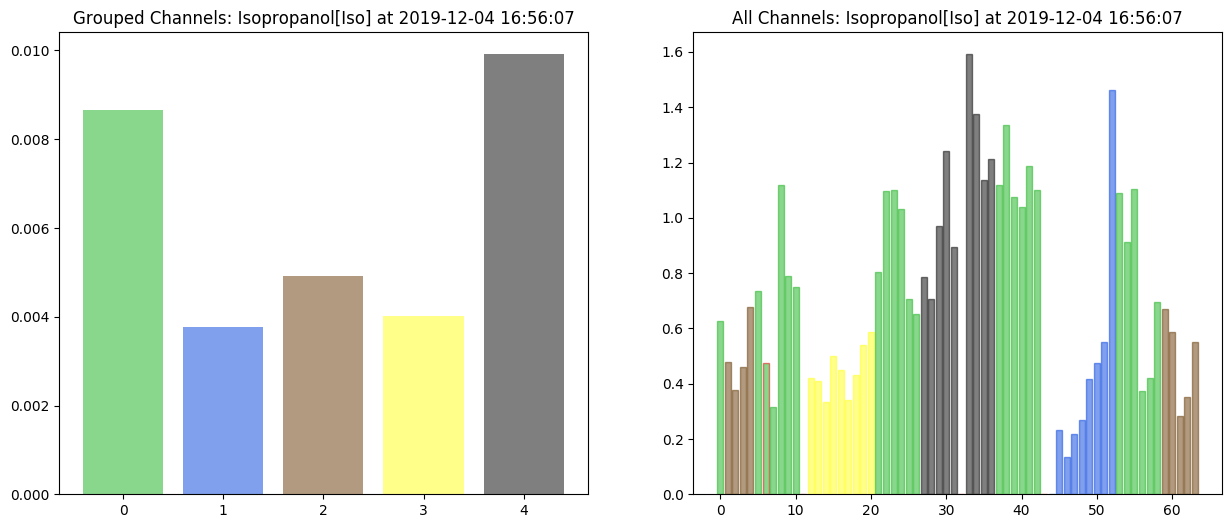

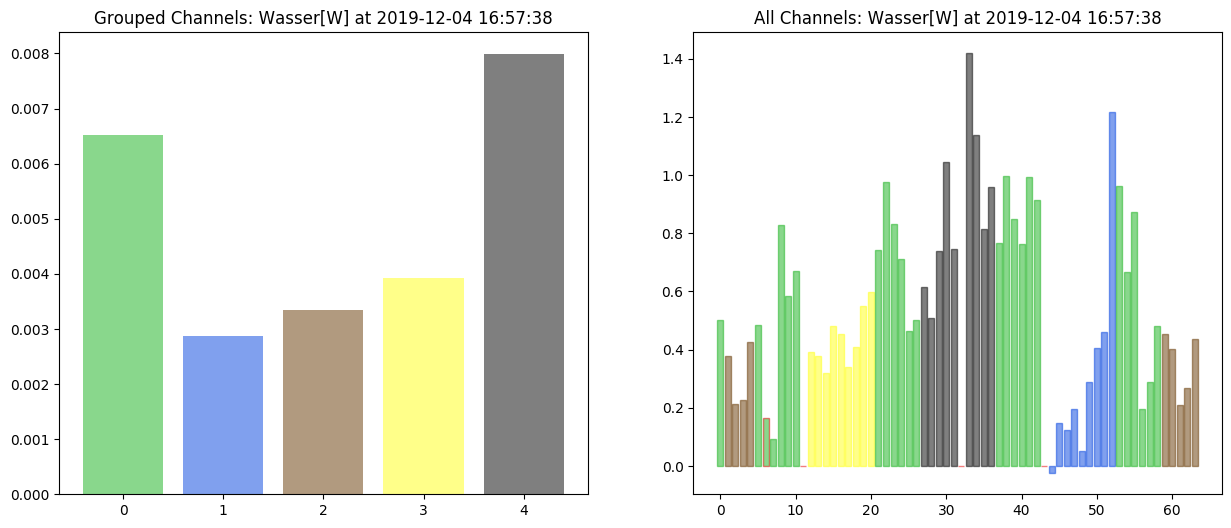

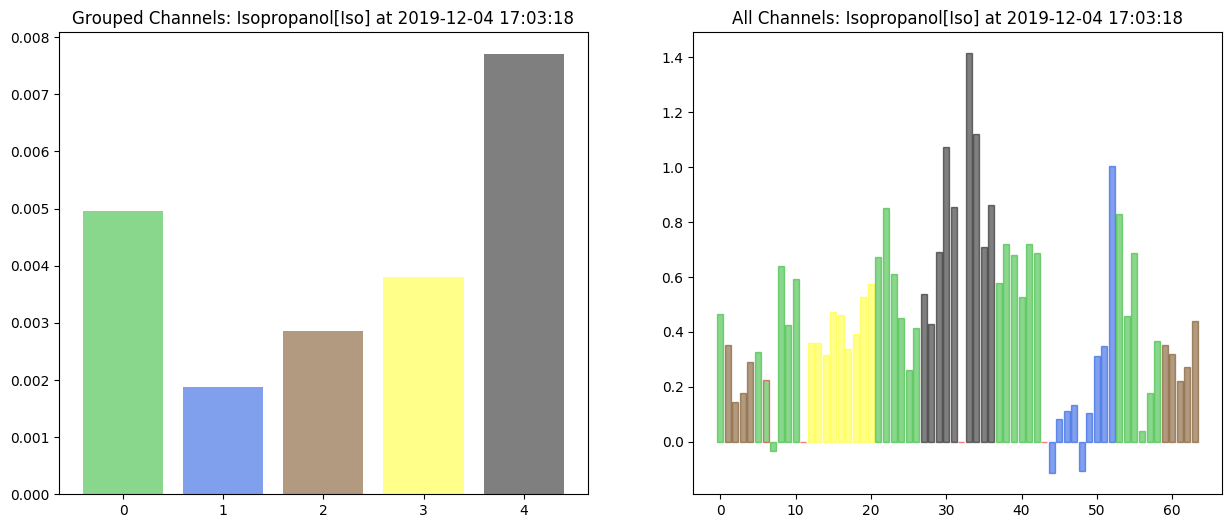

In [18]:
pretty_draw_meas(measurements, functionalisations, failures, show_all_channels=True)

In [20]:
def pretty_draw_direct_comp(measurements, functionalisations, failures=None, show_all_channels=False):
    measurements_grouped_by_label = {}
    colors = ['xkcd:green','xkcd:blue','xkcd:brown','xkcd:yellow','xkcd:black']

    groups = np.unique(functionalisations)
    y_pos = np.arange(len(groups))
    
    for ts in measurements:
        if measurements[ts]['label'] not in measurements_grouped_by_label:
            measurements_grouped_by_label[measurements[ts]['label']] = {}
        measurements_grouped_by_label[measurements[ts]['label']][ts] = measurements[ts]
        
    for label in measurements_grouped_by_label:
        fig, ax = plt.subplots()
        count = 0
        width = 1/len(measurements_grouped_by_label[label])
        for ts in measurements_grouped_by_label[label]:
            bar = ax.bar(y_pos + width*count, 100*(measurements_grouped_by_label[label][ts]['func_avg']-1),width,align='center',color=colors)
            
            for i in range(len(bar)):
                bar[i].set_edgecolor('xkcd:white')
            count += 1
        ax.set_ylabel('R/R0')
        ax.set_title(label)
        ax.set_xticks([0,1,2,3,4])
        plt.show()

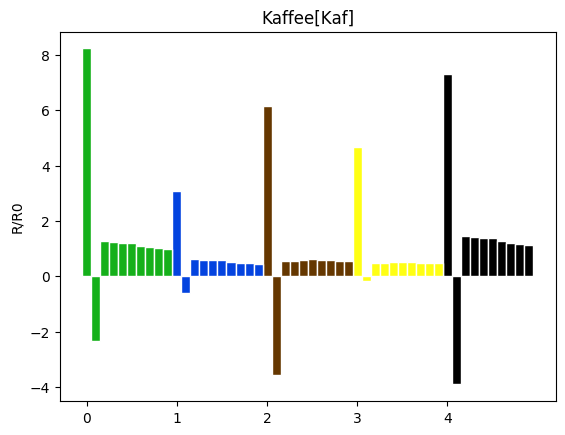

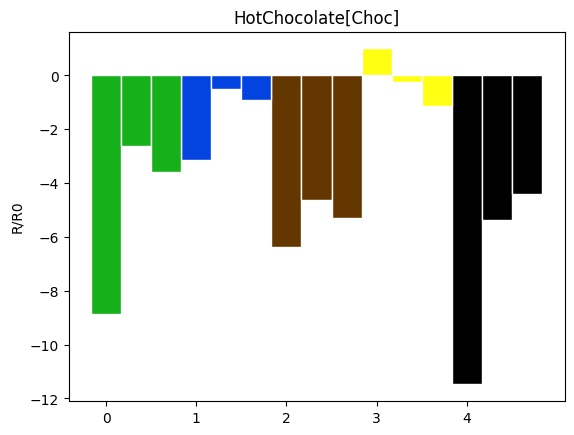

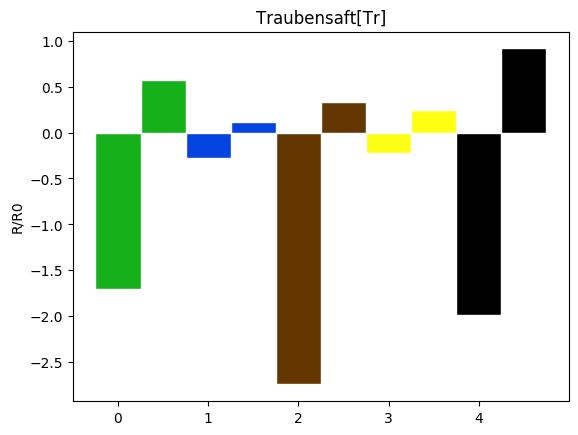

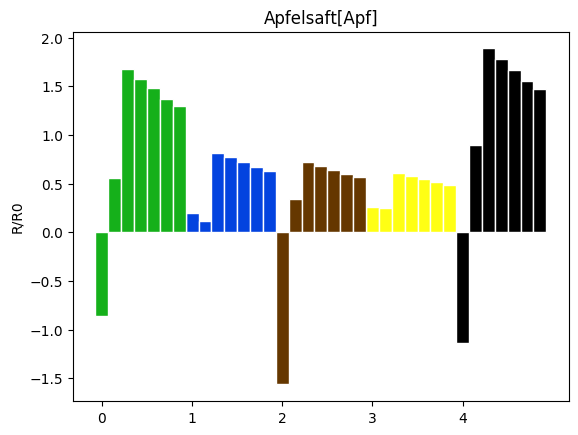

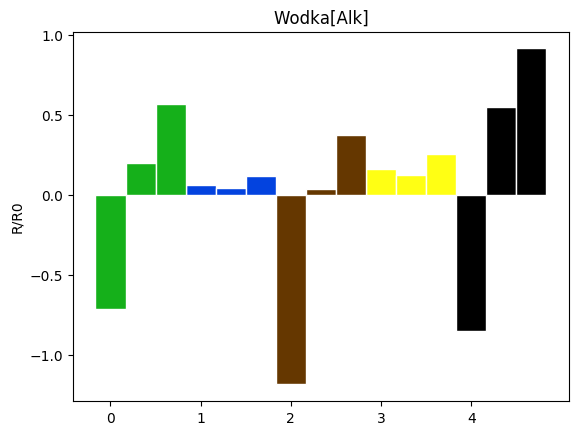

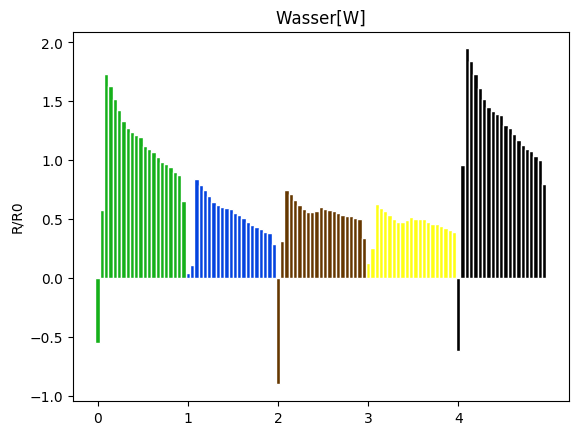

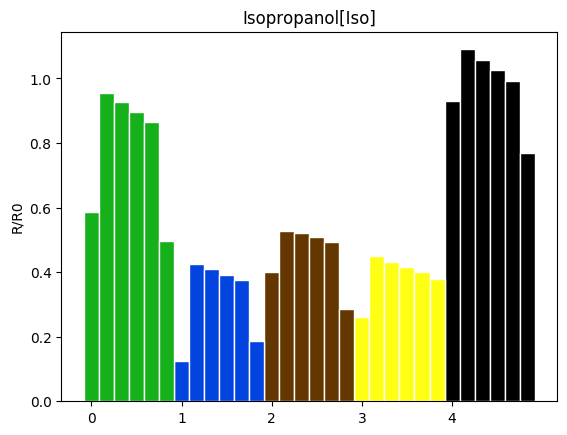

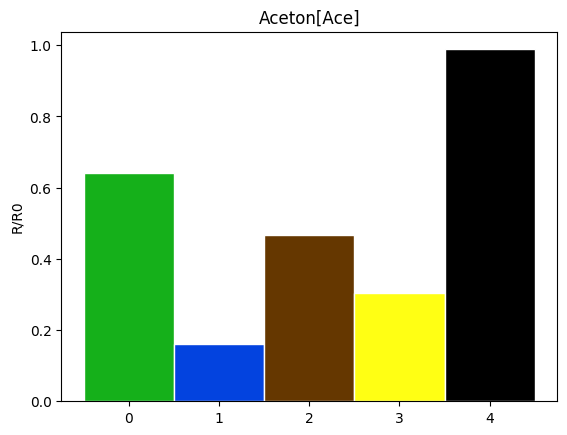

In [21]:
pretty_draw_direct_comp(measurements, functionalisations)

In [25]:
def pretty_print(data):
    for ts in data:
        print(ts,":",data[ts]['channels'],";label:",data[ts]['label'])

In [26]:
def pretty_print_meas(measurements, p):
    for ts in measurements:
        print(ts,"; label:", measurements[ts]['label'])
        if 'avgs' in measurements[ts]:
            print("channel averages:", measurements[ts]['avgs'])   
            
        if 'func_avg' in measurements[ts]:
            print("channel group averages:", measurements[ts]['func_avg'])   
            
        #print(measurements[ts]['data'])
        
        

[-0.175  0.825  1.825  2.825  3.825]


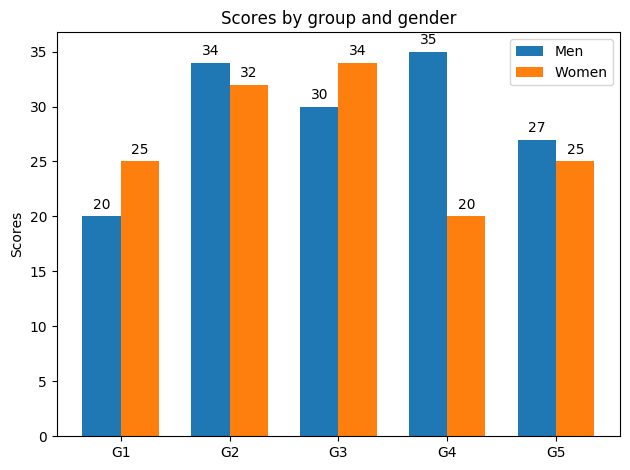

In [27]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
print(x - width/2)
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# PCA

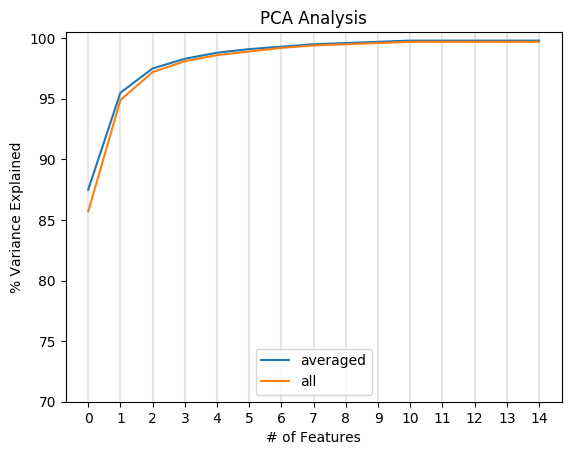

In [28]:
all_the_data_array = None
all_variances = None

count = 0

for ts in measurements:
    if all_the_data_array is None:
        all_the_data_array = measurements[ts]['data']
    else: 
        all_the_data_array = np.vstack((all_the_data_array, measurements[ts]['data']))
        
    #do PCA for every single measurement
    pca_single = PCA(15)
    pca_single.fit_transform(measurements[ts]['data'])
    explained_variance = pca_single.explained_variance_ratio_
    count += 1
    if all_variances is None:
        all_variances = explained_variance
    else:
        all_variances = np.vstack((all_variances, explained_variance))
        

var=np.cumsum(np.round(np.mean(all_variances,axis=0), decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')

plt.title('PCA Analysis')
plt.ylim(70,100.5)

plt.xticks(range(15))

plt.plot(var, label='averaged')

pca = PCA(15)
pca.fit_transform(all_the_data_array)
explained_variance = pca.explained_variance_ratio_

var=np.cumsum(np.round(explained_variance, decimals=3)*100)
plt.plot(var, label='all')
for i in range(15):
    plt.axvline(x=i, alpha=0.2, color="grey")

plt.legend()
plt.show()

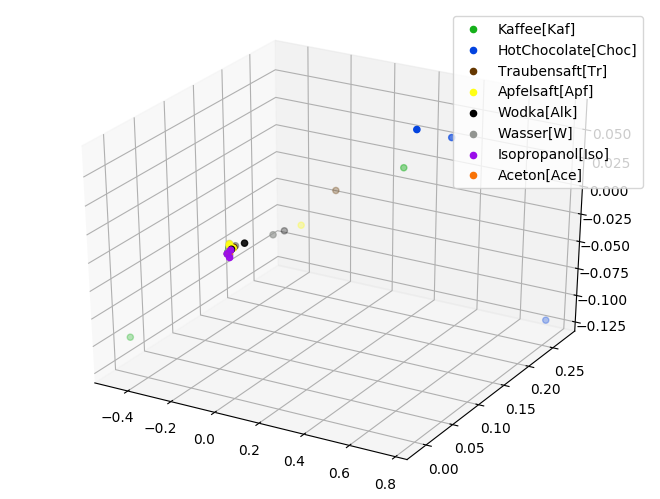

In [29]:
pca = PCA(3)
pca.fit_transform(all_the_data_array)

fig = plt.figure()
ax = Axes3D(fig)

measurements_grouped_by_label = {}
colors = ['xkcd:green','xkcd:blue','xkcd:brown','xkcd:yellow','xkcd:black','xkcd:grey','xkcd:violet','xkcd:orange','xkcd:red']

groups = np.unique(functionalisations)
y_pos = np.arange(len(groups))

for ts in measurements:
    if measurements[ts]['label'] not in measurements_grouped_by_label:
        measurements_grouped_by_label[measurements[ts]['label']] = {}
    measurements_grouped_by_label[measurements[ts]['label']][ts] = measurements[ts]

count = 0
for label in measurements_grouped_by_label:
    xs = []
    ys = []
    zs = []
    
    for ts in measurements_grouped_by_label[label]:
        tmp = pca.transform(measurements_grouped_by_label[label][ts]['avgs'].reshape(1, -1))
        x,y,z = tmp[0]
        xs.append(x)
        ys.append(y)
        zs.append(z)
    
    ax.scatter(xs, ys, zs, color=colors[count], label=label)
    count+=1
    
plt.legend()
plt.show()
      

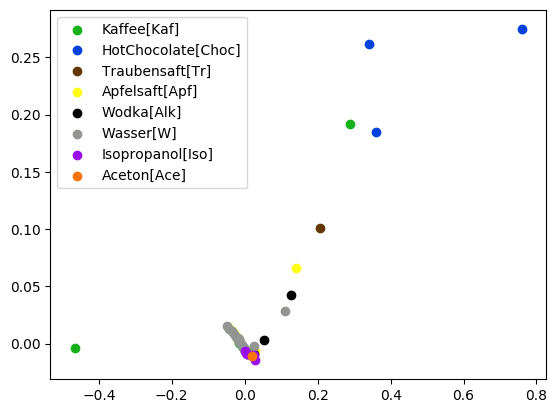

In [30]:
pca = PCA(2)
pca.fit_transform(all_the_data_array)

fig, ax = plt.subplots()

measurements_grouped_by_label = {}
colors = ['xkcd:green','xkcd:blue','xkcd:brown','xkcd:yellow','xkcd:black','xkcd:grey','xkcd:violet','xkcd:orange','xkcd:red']

groups = np.unique(functionalisations)
y_pos = np.arange(len(groups))

for ts in measurements:
    if measurements[ts]['label'] not in measurements_grouped_by_label:
        measurements_grouped_by_label[measurements[ts]['label']] = {}
    measurements_grouped_by_label[measurements[ts]['label']][ts] = measurements[ts]

count = 0
for label in measurements_grouped_by_label:
    xs = []
    ys = []
    
    for ts in measurements_grouped_by_label[label]:
        tmp = pca.transform(measurements_grouped_by_label[label][ts]['avgs'].reshape(1, -1))
        x,y = tmp[0]
        xs.append(x)
        ys.append(y)
    
    ax.scatter(xs, ys, color=colors[count], label=label)
    count+=1
    
plt.legend()
plt.show()

# tSNE